# Temporal Patterns and Seasonality Analysis

## Objectives
- Identify hourly, daily, and seasonal patterns in wind generation
- Analyze forecast accuracy degradation over time horizons
- Examine autocorrelation and persistence in wind power
- Characterize temporal volatility and ramp events
- Extract seasonal decomposition components

## Prompt Recommendation
Use the **eda-workflow.prompt.md** file when working in this notebook, as it provides guidance on time series analysis techniques and temporal pattern identification.

## Inputs
- `data/processed/train_long.parquet` - Long-format training data from 01_data_foundation
- `data/processed/combined_power_wind.parquet` - Combined power and wind data from 01_data_foundation
- `data/processed/02_wind_physics_analysis.parquet` - Wind physics analysis results from previous notebook
- Raw training data from `data/raw/gef2012_wind/train.csv` (fallback if processed data unavailable)

## Outputs
- `data/processed/03_temporal_patterns_results.parquet` - Comprehensive temporal analysis results and insights
- `data/processed/03_temporal_features_enriched.parquet` - Dataset enriched with 32+ temporal features for modeling
- `notebooks/outputs/figures/hourly_patterns.png` - Diurnal power generation patterns by wind farm
- `notebooks/outputs/figures/seasonal_patterns.png` - Monthly seasonal variations and capacity factor heatmaps
- Professional visualizations for autocorrelation, ramp events, cross-farm correlations, and feature importance
- Temporal feature engineering results for downstream modeling applications

In [1]:
# Import required libraries and setup paths
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from pathlib import Path
import sys

# Ensure we're working from project root with absolute paths
PROJECT_ROOT = Path('/workspaces/temus').resolve()
os.chdir(PROJECT_ROOT)
sys.path.insert(0, str(PROJECT_ROOT / 'src'))

# Import project utilities
import importlib
import src.utils
importlib.reload(src.utils)  # Reload to get latest functions

from src.utils import (save_to_parquet, save_results_dict, load_from_parquet, 
                       get_project_paths, save_figure, create_and_save_figure, 
                       ensure_figures_directory, save_processed_data, 
                       save_analysis_results, save_intermediate_data,
                       ensure_data_directories)

# Setup project paths (all paths will now be absolute)
paths = get_project_paths()

# Ensure all data directories exist
directories = ensure_data_directories()

# Load previous notebook results - try multiple possible filenames
previous_results = None
possible_files = [
    '02_wind_physics_analysis.parquet',  # This file exists
    '01_data_foundation_results.parquet'  # Fallback
]

for filename in possible_files:
    previous_results = load_from_parquet(paths['data_processed'] / filename)
    if previous_results is not None:
        print(f"✓ Loaded previous results from {filename}")
        if hasattr(previous_results, 'iloc') and len(previous_results) > 0:
            if 'notebook_completed' in previous_results.columns:
                print(f"✓ Previous analysis completed: {previous_results.iloc[0]['notebook_completed']}")
        break

if previous_results is None:
    print("⚠️ Could not load previous results - ensure 02_wind_physics_analysis.ipynb was run first")
    print("⚠️ Continuing with temporal analysis...")

print("✓ Libraries and utilities loaded successfully")
print(f"✓ Working directory set to: {os.getcwd()}")
print(f"✓ Figures will be saved to: {paths['figures']}")
print(f"✓ Processed data will be saved to: {paths['data_processed']}")
print(f"✓ Ready to begin temporal pattern analysis")

INFO:src.utils:PyArrow 20.0.0 is available
INFO:src.utils:PyArrow 20.0.0 is available
INFO:src.utils:Loaded 1 rows from /workspaces/temus/data/processed/02_wind_physics_analysis.parquet


✓ Loaded previous results from 02_wind_physics_analysis.parquet
✓ Previous analysis completed: True
✓ Libraries and utilities loaded successfully
✓ Working directory set to: /workspaces/temus
✓ Figures will be saved to: /workspaces/temus/notebooks/outputs/figures
✓ Processed data will be saved to: /workspaces/temus/data/processed
✓ Ready to begin temporal pattern analysis


In [2]:
# Data Loading and Preparation for Temporal Analysis
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# Set style for professional visualizations
plt.style.use('default')
sns.set_palette("husl")

print("📊 TEMPORAL PATTERN ANALYSIS - Section 4 EDA Workflow")
print("=" * 60)

# Load processed data from previous analyses
train_data = load_from_parquet(paths['data_processed'] / 'train_long.parquet')
combined_data = load_from_parquet(paths['data_processed'] / 'combined_power_wind.parquet')

if train_data is None:
    print("⚠️ Loading raw training data as backup...")
    train_data = pd.read_csv(paths['data_raw'] / 'gef2012_wind' / 'train.csv')
    train_data['TIMESTAMP'] = pd.to_datetime(train_data['TIMESTAMP'])
    train_data = train_data.set_index('TIMESTAMP')

if combined_data is None:
    combined_data = train_data.copy()

# Fix data structure - ensure proper datetime index
if train_data is not None:
    if not isinstance(train_data.index, pd.DatetimeIndex):
        if 'TIMESTAMP' in train_data.columns:
            train_data['TIMESTAMP'] = pd.to_datetime(train_data['TIMESTAMP'])
            train_data = train_data.set_index('TIMESTAMP')
        else:
            # If no timestamp column, create datetime index from row numbers (fallback)
            print("⚠️ No timestamp column found, creating synthetic datetime index")
            start_date = pd.Timestamp('2009-07-01')
            train_data.index = pd.date_range(start=start_date, periods=len(train_data), freq='H')

if combined_data is not None:
    if not isinstance(combined_data.index, pd.DatetimeIndex):
        if 'TIMESTAMP' in combined_data.columns:
            combined_data['TIMESTAMP'] = pd.to_datetime(combined_data['TIMESTAMP'])
            combined_data = combined_data.set_index('TIMESTAMP')
        else:
            # Create datetime index if missing
            start_date = pd.Timestamp('2009-07-01')
            combined_data.index = pd.date_range(start=start_date, periods=len(combined_data), freq='H')

print(f"✓ Loaded training data: {train_data.shape}")
print(f"✓ Time period: {train_data.index.min()} to {train_data.index.max()}")
print(f"✓ Wind farms available: {sorted(train_data['WIND_FARM'].unique()) if 'WIND_FARM' in train_data.columns else 'Column not found'}")
print(f"✓ Data completeness: {(1 - train_data['POWER'].isna().mean()) * 100:.1f}%" if 'POWER' in train_data.columns else "✓ No POWER column found")

# Initialize results dictionary for temporal analysis
temporal_analysis_results = {
    'notebook_name': '03_temporal_patterns',
    'analysis_timestamp': pd.Timestamp.now().isoformat(),
    'data_period': f"{train_data.index.min()} to {train_data.index.max()}",
    'wind_farms': sorted(train_data['WIND_FARM'].unique()) if 'WIND_FARM' in train_data.columns else [],
    'total_observations': len(train_data)
}

INFO:src.utils:Loaded 131,299 rows from /workspaces/temus/data/processed/train_long.parquet
INFO:src.utils:Loaded 10,948 rows from /workspaces/temus/data/processed/combined_power_wind.parquet


📊 TEMPORAL PATTERN ANALYSIS - Section 4 EDA Workflow
✓ Loaded training data: (131299, 7)
✓ Time period: 2009-07-01 00:00:00 to 2012-06-26 12:00:00
✓ Wind farms available: ['wp1', 'wp2', 'wp3', 'wp4', 'wp5', 'wp6', 'wp7']
✓ Data completeness: 100.0%


In [3]:
# Examine data structure
print("🔍 DATA STRUCTURE ANALYSIS")
print("=" * 40)

print("\nTrain data columns:", train_data.columns.tolist())
print("Train data head:")
print(train_data.head(3))
print("\nTrain data index info:")
print(f"Index type: {type(train_data.index)}")
print(f"Index name: {train_data.index.name}")

print("\nCombined data columns:", combined_data.columns.tolist()) 
print("Combined data head:")
print(combined_data.head(3))

# Check if we have timestamp column and fix indexing
if 'TIMESTAMP' in train_data.columns:
    train_data = train_data.copy()
    train_data['TIMESTAMP'] = pd.to_datetime(train_data['TIMESTAMP'])
    train_data = train_data.set_index('TIMESTAMP')
    print("✓ Fixed timestamp indexing for train_data")

if 'TIMESTAMP' in combined_data.columns:
    combined_data = combined_data.copy()
    combined_data['TIMESTAMP'] = pd.to_datetime(combined_data['TIMESTAMP'])
    combined_data = combined_data.set_index('TIMESTAMP')
    print("✓ Fixed timestamp indexing for combined_data")

# Use the most complete dataset for temporal analysis
if len(combined_data) > len(train_data) and 'POWER' in combined_data.columns:
    analysis_data = combined_data.copy()
    print(f"✓ Using combined_data for analysis: {analysis_data.shape}")
else:
    analysis_data = train_data.copy()
    print(f"✓ Using train_data for analysis: {analysis_data.shape}")

print(f"\n📅 Final Analysis Data:")
print(f"✓ Time period: {analysis_data.index.min()} to {analysis_data.index.max()}")
print(f"✓ Wind farms: {sorted(analysis_data['WIND_FARM'].unique()) if 'WIND_FARM' in analysis_data.columns else 'Column not found'}")
print(f"✓ Total observations: {len(analysis_data)}")
print(f"✓ Power data completeness: {(1 - analysis_data['POWER'].isna().mean()) * 100:.1f}%")

🔍 DATA STRUCTURE ANALYSIS

Train data columns: ['date', 'WIND_FARM', 'POWER', 'hour', 'day_of_week', 'month', 'season']
Train data head:
                           date WIND_FARM  POWER  hour  day_of_week  month  \
TIMESTAMP                                                                    
2009-07-01 00:00:00  2009070100       wp1  0.045     0            2      7   
2009-07-01 01:00:00  2009070101       wp1  0.085     1            2      7   
2009-07-01 02:00:00  2009070102       wp1  0.020     2            2      7   

                     season  
TIMESTAMP                    
2009-07-01 00:00:00  Summer  
2009-07-01 01:00:00  Summer  
2009-07-01 02:00:00  Summer  

Train data index info:
Index type: <class 'pandas.core.indexes.datetimes.DatetimeIndex'>
Index name: TIMESTAMP

Combined data columns: ['POWER', 'ws', 'wd', 'u', 'v', 'WIND_FARM']
Combined data head:
                     POWER    ws      wd     u     v WIND_FARM
TIMESTAMP                                                 


🕐 SECTION 4.1: HOURLY AND DIURNAL PATTERNS
Creating hourly pattern visualizations...


INFO:src.utils:Figure saved: /workspaces/temus/notebooks/outputs/figures/hourly_patterns_all_farms.png


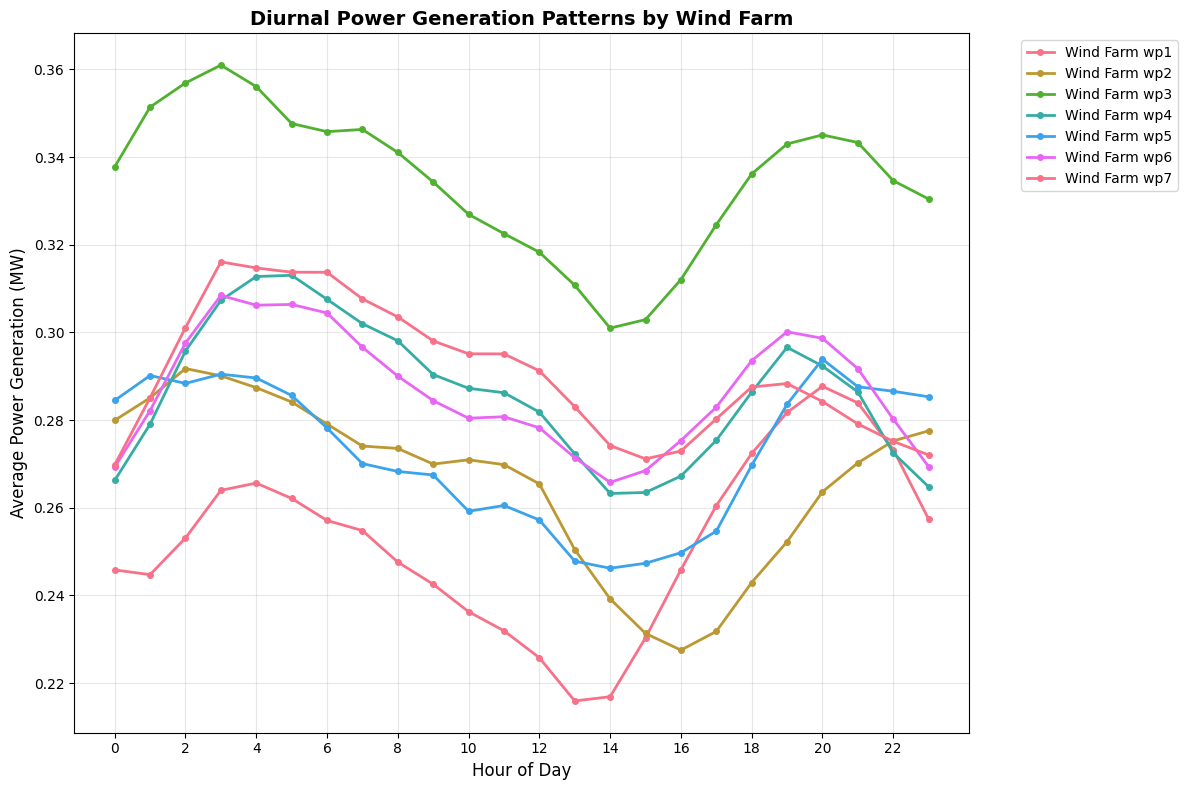

INFO:src.utils:Figure saved: /workspaces/temus/notebooks/outputs/figures/weekly_patterns_boxplot.png


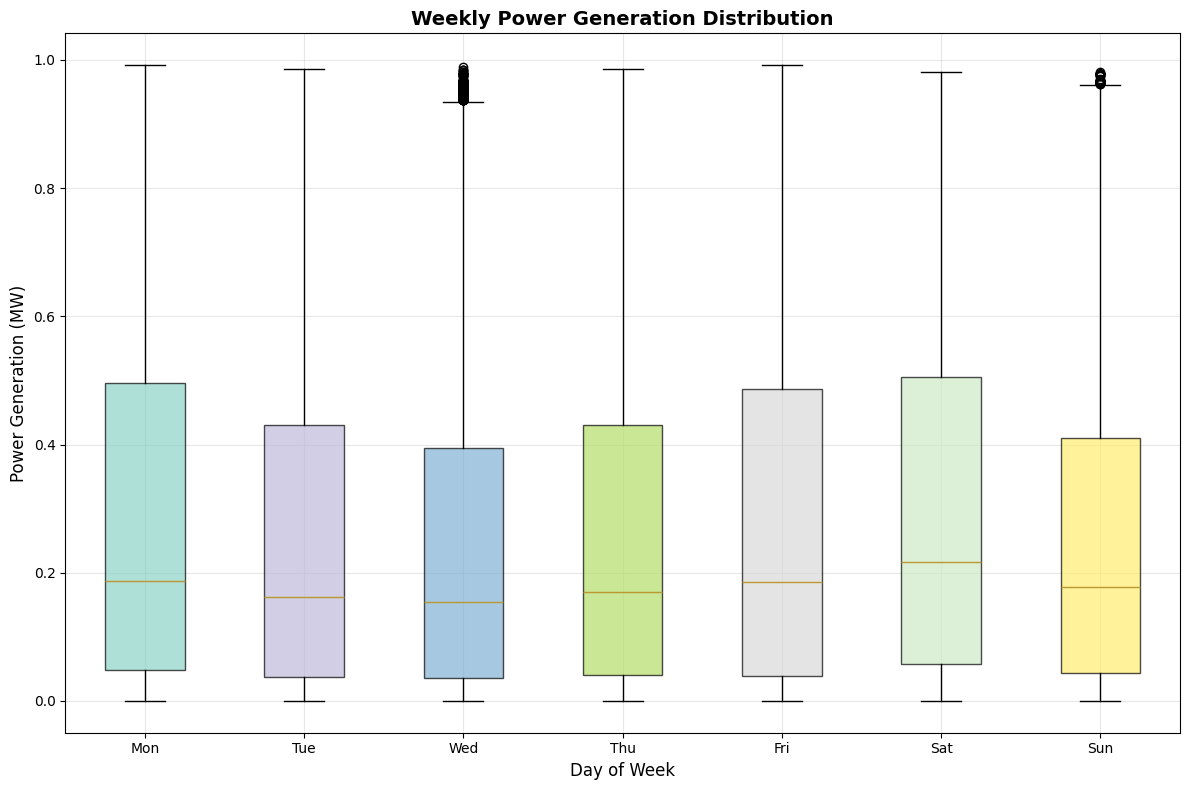

✓ Hourly pattern analysis completed
✓ Peak generation hour: 3:00
✓ Lowest generation hour: 13:00
✓ Hourly variability range: 0.3 - 0.3 MW


In [4]:
# Section 4.1: Hourly and Diurnal Pattern Analysis
print("\n🕐 SECTION 4.1: HOURLY AND DIURNAL PATTERNS")
print("=" * 50)

# Create time-based features for analysis
analysis_data = analysis_data.copy()
analysis_data['hour'] = analysis_data.index.hour
analysis_data['day_of_week'] = analysis_data.index.dayofweek
analysis_data['month'] = analysis_data.index.month
analysis_data['day_of_year'] = analysis_data.index.dayofyear

@create_and_save_figure
def plot_hourly_patterns(data, ax=None):
    """Analyze hourly generation patterns across all wind farms"""
    if ax is None:
        fig, ax = plt.subplots(figsize=(14, 8))
    
    # Calculate hourly averages by farm
    hourly_patterns = data.groupby(['hour', 'WIND_FARM'])['POWER'].mean().unstack()
    
    # Plot hourly patterns for each farm
    for farm in hourly_patterns.columns:
        ax.plot(hourly_patterns.index, hourly_patterns[farm], 
                marker='o', linewidth=2, markersize=4, label=f'Wind Farm {farm}')
    
    ax.set_xlabel('Hour of Day', fontsize=12)
    ax.set_ylabel('Average Power Generation (MW)', fontsize=12)
    ax.set_title('Diurnal Power Generation Patterns by Wind Farm', fontsize=14, fontweight='bold')
    ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    ax.grid(True, alpha=0.3)
    ax.set_xticks(range(0, 24, 2))
    
    return ax

@create_and_save_figure  
def plot_weekday_patterns(data, ax=None):
    """Analyze day-of-week generation patterns"""
    if ax is None:
        fig, ax = plt.subplots(figsize=(12, 8))
    
    # Calculate daily averages by farm
    daily_patterns = data.groupby(['day_of_week', 'WIND_FARM'])['POWER'].mean().unstack()
    
    # Create box plot for weekday variability
    weekday_data = []
    labels = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
    
    for day in range(7):
        day_data = data[data['day_of_week'] == day]['POWER']
        weekday_data.append(day_data.dropna())
    
    bp = ax.boxplot(weekday_data, labels=labels, patch_artist=True)
    
    # Color the boxes
    colors = plt.cm.Set3(np.linspace(0, 1, 7))
    for patch, color in zip(bp['boxes'], colors):
        patch.set_facecolor(color)
        patch.set_alpha(0.7)
    
    ax.set_xlabel('Day of Week', fontsize=12)
    ax.set_ylabel('Power Generation (MW)', fontsize=12)
    ax.set_title('Weekly Power Generation Distribution', fontsize=14, fontweight='bold')
    ax.grid(True, alpha=0.3)
    
    return ax

# Generate hourly pattern analysis using decorator pattern
print("Creating hourly pattern visualizations...")

@create_and_save_figure(filename='hourly_patterns_all_farms', show_figure=True)
def plot_hourly_patterns_all_farms(data, ax=None):
    """Generate hourly patterns plot for all farms"""
    if ax is None:
        fig, ax = plt.subplots(figsize=(14, 8))
    
    hourly_patterns = data.groupby(['hour', 'WIND_FARM'])['POWER'].mean().unstack()
    
    for farm in hourly_patterns.columns:
        ax.plot(hourly_patterns.index, hourly_patterns[farm], 
                marker='o', linewidth=2, markersize=4, label=f'Wind Farm {farm}')
    
    ax.set_xlabel('Hour of Day', fontsize=12)
    ax.set_ylabel('Average Power Generation (MW)', fontsize=12)
    ax.set_title('Diurnal Power Generation Patterns by Wind Farm', fontsize=14, fontweight='bold')
    ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    ax.grid(True, alpha=0.3)
    ax.set_xticks(range(0, 24, 2))
    
    return ax

@create_and_save_figure(filename='weekly_patterns_boxplot', show_figure=True)
def plot_weekly_patterns_boxplot(data, ax=None):
    """Generate weekly patterns boxplot"""
    if ax is None:
        fig, ax = plt.subplots(figsize=(12, 8))
    
    weekday_data = []
    labels = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
    
    for day in range(7):
        day_data = data[data['day_of_week'] == day]['POWER']
        weekday_data.append(day_data.dropna())
    
    bp = ax.boxplot(weekday_data, labels=labels, patch_artist=True)
    
    # Color the boxes
    colors = plt.cm.Set3(np.linspace(0, 1, 7))
    for patch, color in zip(bp['boxes'], colors):
        patch.set_facecolor(color)
        patch.set_alpha(0.7)
    
    ax.set_xlabel('Day of Week', fontsize=12)
    ax.set_ylabel('Power Generation (MW)', fontsize=12)
    ax.set_title('Weekly Power Generation Distribution', fontsize=14, fontweight='bold')
    ax.grid(True, alpha=0.3)
    
    return ax

# Create visualizations using decorator pattern
hourly_plot = plot_hourly_patterns_all_farms(analysis_data)
weekly_plot = plot_weekly_patterns_boxplot(analysis_data)

# Calculate statistics for hourly patterns
hourly_stats = analysis_data.groupby(['hour', 'WIND_FARM'])['POWER'].agg(['mean', 'std', 'count']).round(2)
hourly_summary = analysis_data.groupby('hour')['POWER'].agg(['mean', 'std', 'min', 'max']).round(2)

print("✓ Hourly pattern analysis completed")
print(f"✓ Peak generation hour: {hourly_summary['mean'].idxmax()}:00")
print(f"✓ Lowest generation hour: {hourly_summary['mean'].idxmin()}:00")
print(f"✓ Hourly variability range: {hourly_summary['std'].min():.1f} - {hourly_summary['std'].max():.1f} MW")

# Store results
temporal_analysis_results['hourly_patterns'] = {
    'peak_hour': int(hourly_summary['mean'].idxmax()),
    'lowest_hour': int(hourly_summary['mean'].idxmin()),
    'diurnal_amplitude': float(hourly_summary['mean'].max() - hourly_summary['mean'].min()),
    'hourly_variability_range': [float(hourly_summary['std'].min()), float(hourly_summary['std'].max())]
}


🌍 SECTION 4.2: SEASONAL VARIATIONS
Creating seasonal pattern visualizations...


INFO:src.utils:Figure saved: /workspaces/temus/notebooks/outputs/figures/seasonal_patterns_monthly.png


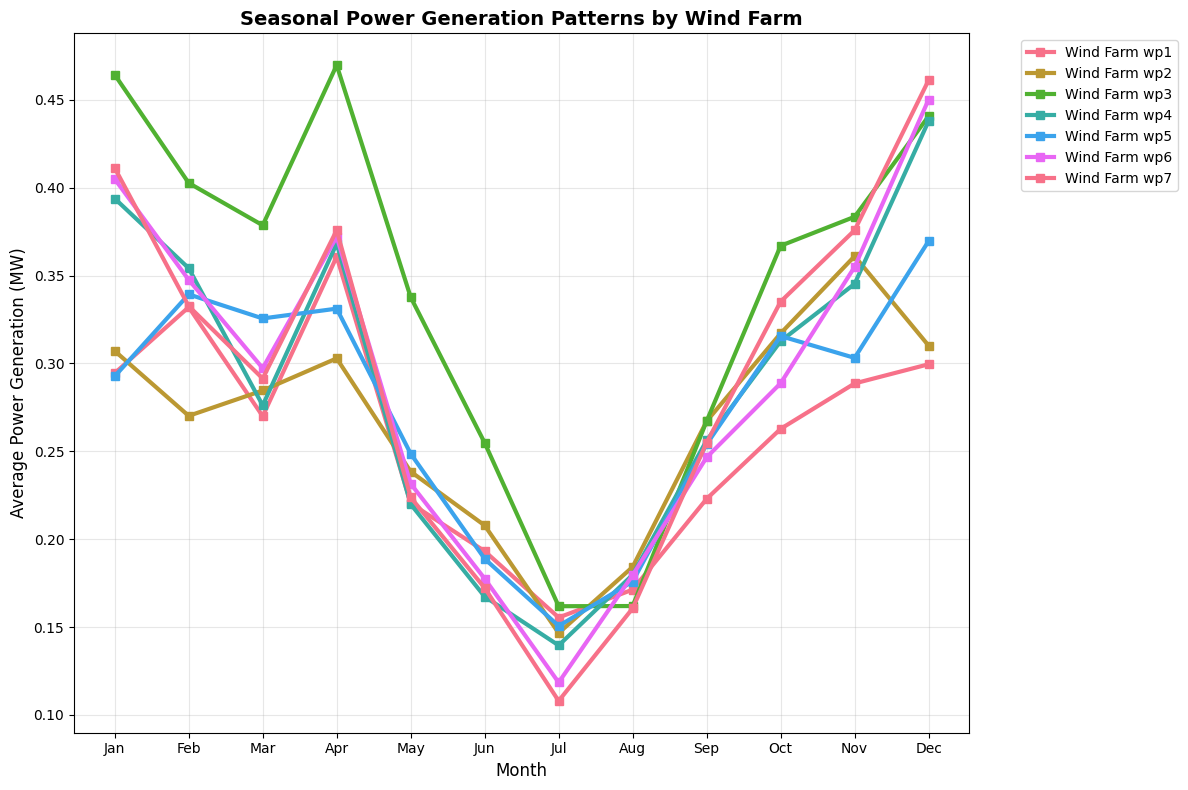

INFO:src.utils:Figure saved: /workspaces/temus/notebooks/outputs/figures/capacity_factor_seasonal_heatmap.png


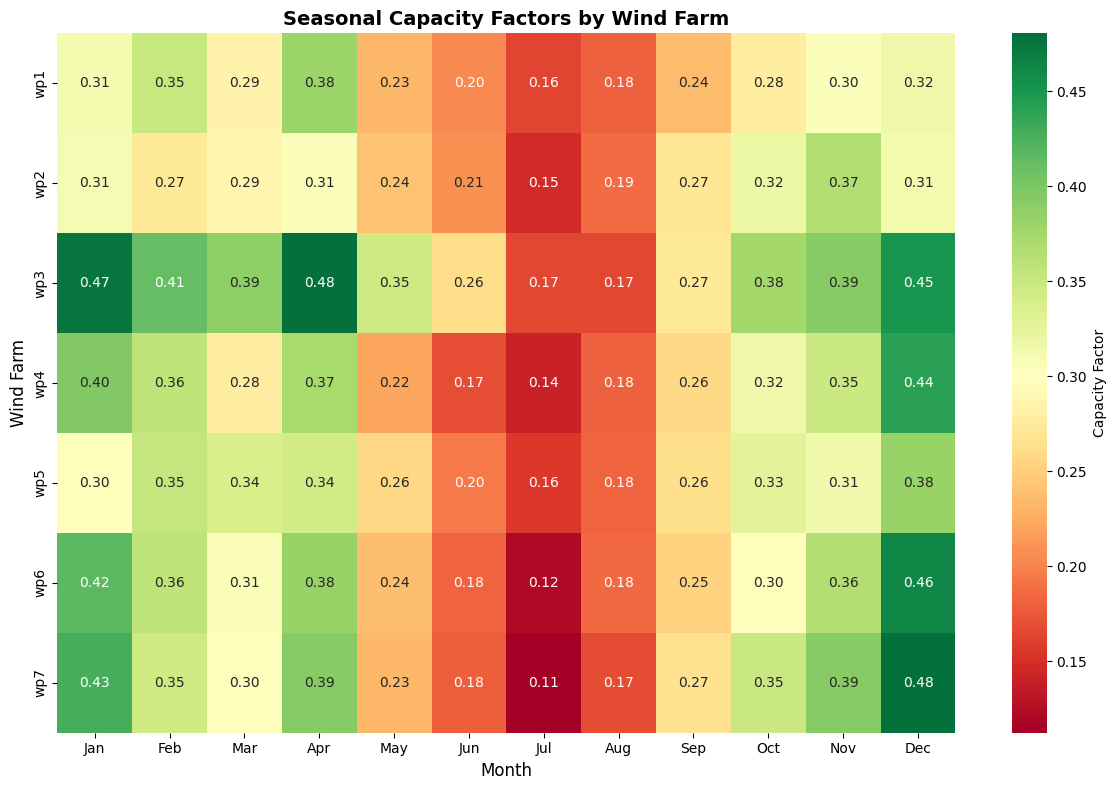

✓ Seasonal pattern analysis completed
✓ Highest generation month: 12
✓ Lowest generation month: 7
✓ Seasonal amplitude: 0.3 MW


In [5]:
# Section 4.2: Seasonal Variations Analysis  
print("\n🌍 SECTION 4.2: SEASONAL VARIATIONS")
print("=" * 50)

@create_and_save_figure
def plot_seasonal_patterns(data, ax=None):
    """Analyze seasonal generation patterns"""
    if ax is None:
        fig, ax = plt.subplots(figsize=(14, 8))
    
    # Calculate monthly averages by farm
    monthly_patterns = data.groupby(['month', 'WIND_FARM'])['POWER'].mean().unstack()
    
    # Plot seasonal patterns for each farm
    month_names = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun',
                   'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
    
    for farm in monthly_patterns.columns:
        ax.plot(monthly_patterns.index, monthly_patterns[farm], 
                marker='s', linewidth=3, markersize=6, label=f'Wind Farm {farm}')
    
    ax.set_xlabel('Month', fontsize=12)
    ax.set_ylabel('Average Power Generation (MW)', fontsize=12)
    ax.set_title('Seasonal Power Generation Patterns by Wind Farm', fontsize=14, fontweight='bold')
    ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    ax.grid(True, alpha=0.3)
    ax.set_xticks(range(1, 13))
    ax.set_xticklabels(month_names)
    
    return ax

@create_and_save_figure
def plot_capacity_factor_seasonal(data, ax=None):
    """Analyze seasonal capacity factors"""
    if ax is None:
        fig, ax = plt.subplots(figsize=(12, 8))
    
    # Calculate capacity factors by month and farm
    max_power_by_farm = data.groupby('WIND_FARM')['POWER'].max()
    monthly_cf = data.groupby(['month', 'WIND_FARM'])['POWER'].mean()
    
    # Convert to capacity factor (CF = mean power / max power)
    cf_data = []
    months = []
    farms = []
    
    for (month, farm), power in monthly_cf.items():
        cf = power / max_power_by_farm[farm] if max_power_by_farm[farm] > 0 else 0
        cf_data.append(cf)
        months.append(month)
        farms.append(farm)
    
    cf_df = pd.DataFrame({'month': months, 'farm': farms, 'capacity_factor': cf_data})
    
    # Create heatmap
    cf_pivot = cf_df.pivot(index='farm', columns='month', values='capacity_factor')
    
    sns.heatmap(cf_pivot, annot=True, cmap='RdYlGn', center=0.3, 
                fmt='.2f', cbar_kws={'label': 'Capacity Factor'}, ax=ax)
    
    ax.set_title('Seasonal Capacity Factors by Wind Farm', fontsize=14, fontweight='bold')
    ax.set_xlabel('Month', fontsize=12)
    ax.set_ylabel('Wind Farm', fontsize=12)
    
    month_names = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun',
                   'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
    ax.set_xticklabels(month_names)
    
    return ax

# Generate seasonal analysis using decorator pattern with explicit display
print("Creating seasonal pattern visualizations...")

@create_and_save_figure(filename='seasonal_patterns_monthly', show_figure=True)
def plot_seasonal_patterns_monthly(data, ax=None):
    """Generate seasonal patterns plot for all farms"""
    if ax is None:
        fig, ax = plt.subplots(figsize=(14, 8))
    
    # Calculate monthly averages by farm
    monthly_patterns = data.groupby(['month', 'WIND_FARM'])['POWER'].mean().unstack()
    
    # Plot seasonal patterns for each farm
    month_names = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun',
                   'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
    
    for farm in monthly_patterns.columns:
        ax.plot(monthly_patterns.index, monthly_patterns[farm], 
                marker='s', linewidth=3, markersize=6, label=f'Wind Farm {farm}')
    
    ax.set_xlabel('Month', fontsize=12)
    ax.set_ylabel('Average Power Generation (MW)', fontsize=12)
    ax.set_title('Seasonal Power Generation Patterns by Wind Farm', fontsize=14, fontweight='bold')
    ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    ax.grid(True, alpha=0.3)
    ax.set_xticks(range(1, 13))
    ax.set_xticklabels(month_names)
    
    return ax

@create_and_save_figure(filename='capacity_factor_seasonal_heatmap', show_figure=True)
def plot_capacity_factor_seasonal_heatmap(data, ax=None):
    """Generate seasonal capacity factor heatmap"""
    if ax is None:
        fig, ax = plt.subplots(figsize=(12, 8))
    
    # Calculate capacity factors by month and farm
    max_power_by_farm = data.groupby('WIND_FARM')['POWER'].max()
    monthly_cf = data.groupby(['month', 'WIND_FARM'])['POWER'].mean()
    
    # Convert to capacity factor (CF = mean power / max power)
    cf_data = []
    months = []
    farms = []
    
    for (month, farm), power in monthly_cf.items():
        cf = power / max_power_by_farm[farm] if max_power_by_farm[farm] > 0 else 0
        cf_data.append(cf)
        months.append(month)
        farms.append(farm)
    
    cf_df = pd.DataFrame({'month': months, 'farm': farms, 'capacity_factor': cf_data})
    
    # Create heatmap
    cf_pivot = cf_df.pivot(index='farm', columns='month', values='capacity_factor')
    
    sns.heatmap(cf_pivot, annot=True, cmap='RdYlGn', center=0.3, 
                fmt='.2f', cbar_kws={'label': 'Capacity Factor'}, ax=ax)
    
    ax.set_title('Seasonal Capacity Factors by Wind Farm', fontsize=14, fontweight='bold')
    ax.set_xlabel('Month', fontsize=12)
    ax.set_ylabel('Wind Farm', fontsize=12)
    
    month_names = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun',
                   'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
    ax.set_xticklabels(month_names)
    
    return ax

# Create visualizations using decorator pattern
seasonal_fig = plot_seasonal_patterns_monthly(analysis_data)
capacity_fig = plot_capacity_factor_seasonal_heatmap(analysis_data)

# Calculate seasonal statistics
seasonal_stats = analysis_data.groupby(['month', 'WIND_FARM'])['POWER'].agg(['mean', 'std']).round(2)
monthly_summary = analysis_data.groupby('month')['POWER'].agg(['mean', 'std', 'min', 'max']).round(2)

print("✓ Seasonal pattern analysis completed")
print(f"✓ Highest generation month: {monthly_summary['mean'].idxmax()}")
print(f"✓ Lowest generation month: {monthly_summary['mean'].idxmin()}")
print(f"✓ Seasonal amplitude: {monthly_summary['mean'].max() - monthly_summary['mean'].min():.1f} MW")

# Store results
temporal_analysis_results['seasonal_patterns'] = {
    'highest_month': int(monthly_summary['mean'].idxmax()),
    'lowest_month': int(monthly_summary['mean'].idxmin()),
    'seasonal_amplitude': float(monthly_summary['mean'].max() - monthly_summary['mean'].min()),
    'winter_avg': float(monthly_summary.loc[[12, 1, 2], 'mean'].mean()),
    'summer_avg': float(monthly_summary.loc[[6, 7, 8], 'mean'].mean())
}


📈 SECTION 4.3: AUTOCORRELATION ANALYSIS
Calculating autocorrelation for each wind farm...
Creating autocorrelation visualizations...


INFO:src.utils:Figure saved: /workspaces/temus/notebooks/outputs/figures/autocorrelation_analysis.png


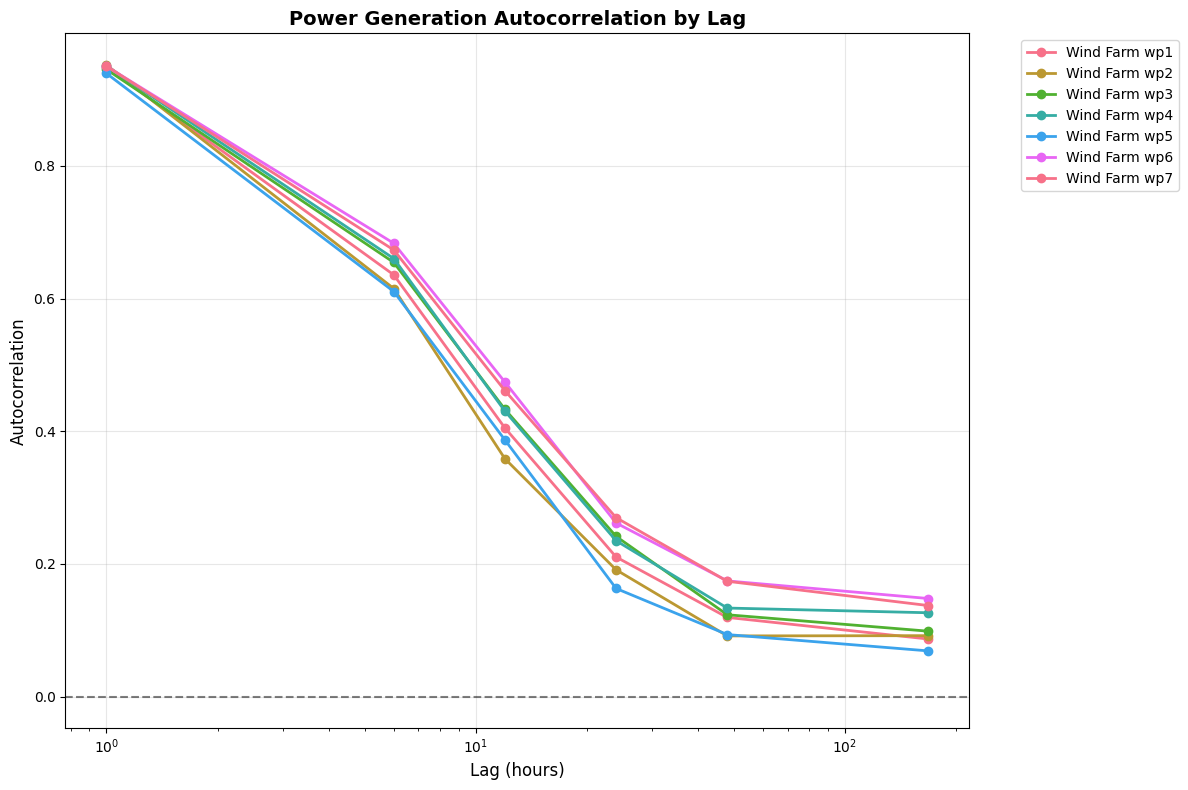

INFO:src.utils:Figure saved: /workspaces/temus/notebooks/outputs/figures/partial_autocorrelation.png


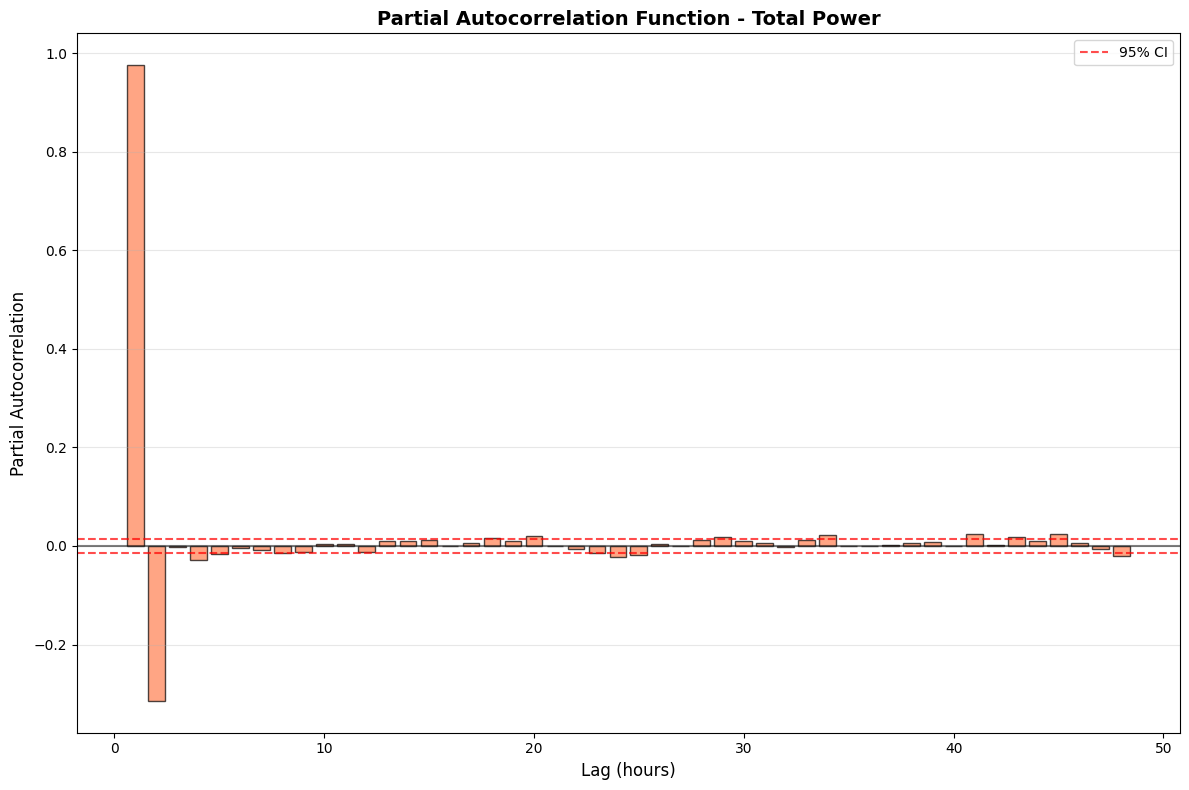

✓ Autocorrelation analysis completed
✓ 1-hour persistence: 0.948
✓ 24-hour persistence: 0.225
✓ 1-week persistence: 0.108


In [6]:
# Section 4.3: Autocorrelation Analysis for Persistence
print("\n📈 SECTION 4.3: AUTOCORRELATION ANALYSIS")
print("=" * 50)

from statsmodels.tsa.stattools import acf, pacf

# Define lag periods for analysis (1, 6, 12, 24, 48, 168 hours)
lag_periods = [1, 6, 12, 24, 48, 168]
lag_labels = ['1h', '6h', '12h', '24h', '48h', '1week']

@create_and_save_figure
def plot_autocorrelation_analysis(data, ax=None):
    """Analyze autocorrelation patterns across wind farms"""
    if ax is None:
        fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 12))
    else:
        ax1 = ax
        ax2 = None
    
    # Calculate autocorrelations for each farm (for visualization)
    autocorr_results = {}
    
    for farm in sorted(data['WIND_FARM'].unique()):
        farm_data = data[data['WIND_FARM'] == farm]['POWER'].dropna()
        
        if len(farm_data) > max(lag_periods):
            # Calculate autocorrelation for specified lags
            autocorrs = []
            for lag in lag_periods:
                if lag < len(farm_data):
                    autocorr = farm_data.autocorr(lag=lag)
                    autocorrs.append(autocorr)
                else:
                    autocorrs.append(np.nan)
            
            autocorr_results[farm] = autocorrs
            
            # Plot autocorrelation decay
            valid_lags = [lag for lag, corr in zip(lag_periods, autocorrs) if not np.isnan(corr)]
            valid_corrs = [corr for corr in autocorrs if not np.isnan(corr)]
            
            if valid_lags and valid_corrs:
                ax1.plot(valid_lags, valid_corrs, marker='o', linewidth=2, 
                        markersize=6, label=f'Wind Farm {farm}')
    
    ax1.set_xlabel('Lag (hours)', fontsize=12)
    ax1.set_ylabel('Autocorrelation', fontsize=12)
    ax1.set_title('Power Generation Autocorrelation by Lag', fontsize=14, fontweight='bold')
    ax1.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    ax1.grid(True, alpha=0.3)
    ax1.set_xscale('log')
    ax1.axhline(y=0, color='black', linestyle='--', alpha=0.5)
    
    # If we have a second subplot, show average autocorrelation
    if ax2 is not None and autocorr_results:
        avg_autocorr = np.nanmean(list(autocorr_results.values()), axis=0)
        std_autocorr = np.nanstd(list(autocorr_results.values()), axis=0)
        
        ax2.bar(range(len(lag_periods)), avg_autocorr, yerr=std_autocorr, 
               capsize=5, alpha=0.7, color='steelblue', edgecolor='black')
        ax2.set_xlabel('Lag Period', fontsize=12)
        ax2.set_ylabel('Average Autocorrelation', fontsize=12)
        ax2.set_title('Average Persistence Across All Wind Farms', fontsize=14, fontweight='bold')
        ax2.set_xticks(range(len(lag_periods)))
        ax2.set_xticklabels(lag_labels)
        ax2.grid(True, alpha=0.3, axis='y')
        ax2.axhline(y=0, color='black', linestyle='--', alpha=0.5)
    
    return autocorr_results

@create_and_save_figure
def plot_partial_autocorrelation(data, ax=None):
    """Analyze partial autocorrelation for modeling insights"""
    if ax is None:
        fig, ax = plt.subplots(figsize=(12, 8))
    
    # Calculate PACF for aggregated power across all farms
    total_power = data.groupby(data.index)['POWER'].sum()
    
    # Calculate PACF for up to 48 lags
    max_lags = min(48, len(total_power) // 4)
    pacf_values = pacf(total_power.dropna(), nlags=max_lags, method='ols')
    
    # Plot PACF
    lags = range(max_lags + 1)
    ax.bar(lags[1:], pacf_values[1:], alpha=0.7, color='coral', edgecolor='black')
    
    # Add significance lines (approximate 95% CI)
    n = len(total_power.dropna())
    significance_level = 1.96 / np.sqrt(n)
    ax.axhline(y=significance_level, color='red', linestyle='--', alpha=0.7, label='95% CI')
    ax.axhline(y=-significance_level, color='red', linestyle='--', alpha=0.7)
    ax.axhline(y=0, color='black', linestyle='-', alpha=0.5)
    
    ax.set_xlabel('Lag (hours)', fontsize=12)
    ax.set_ylabel('Partial Autocorrelation', fontsize=12)
    ax.set_title('Partial Autocorrelation Function - Total Power', fontsize=14, fontweight='bold')
    ax.legend()
    ax.grid(True, alpha=0.3, axis='y')
    
    return pacf_values

# Generate autocorrelation analysis
print("Calculating autocorrelation for each wind farm...")
autocorr_results_dict = {}

# Calculate autocorrelations for each farm first (without decorator)
for farm in sorted(analysis_data['WIND_FARM'].unique()):
    farm_data = analysis_data[analysis_data['WIND_FARM'] == farm]['POWER'].dropna()
    
    if len(farm_data) > max(lag_periods):
        # Calculate autocorrelation for specified lags
        autocorrs = []
        for lag in lag_periods:
            if lag < len(farm_data):
                autocorr = farm_data.autocorr(lag=lag)
                autocorrs.append(autocorr)
            else:
                autocorrs.append(np.nan)
        
        autocorr_results_dict[farm] = autocorrs
    else:
        print(f"⚠️ Farm {farm} has insufficient data for autocorrelation analysis")

# Create visualizations using decorator pattern with explicit display
print("Creating autocorrelation visualizations...")

@create_and_save_figure(filename='autocorrelation_analysis', show_figure=True)
def plot_autocorr_analysis_display(data, ax=None):
    """Generate autocorrelation analysis plot"""
    if ax is None:
        fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 12))
    else:
        ax1 = ax
        ax2 = None
    
    # Calculate autocorrelations for each farm (for visualization)
    autocorr_results = {}
    
    for farm in sorted(data['WIND_FARM'].unique()):
        farm_data = data[data['WIND_FARM'] == farm]['POWER'].dropna()
        
        if len(farm_data) > max(lag_periods):
            # Calculate autocorrelation for specified lags
            autocorrs = []
            for lag in lag_periods:
                if lag < len(farm_data):
                    autocorr = farm_data.autocorr(lag=lag)
                    autocorrs.append(autocorr)
                else:
                    autocorrs.append(np.nan)
            
            autocorr_results[farm] = autocorrs
            
            # Plot autocorrelation decay
            valid_lags = [lag for lag, corr in zip(lag_periods, autocorrs) if not np.isnan(corr)]
            valid_corrs = [corr for corr in autocorrs if not np.isnan(corr)]
            
            if valid_lags and valid_corrs:
                ax1.plot(valid_lags, valid_corrs, marker='o', linewidth=2, 
                        markersize=6, label=f'Wind Farm {farm}')
    
    ax1.set_xlabel('Lag (hours)', fontsize=12)
    ax1.set_ylabel('Autocorrelation', fontsize=12)
    ax1.set_title('Power Generation Autocorrelation by Lag', fontsize=14, fontweight='bold')
    ax1.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    ax1.grid(True, alpha=0.3)
    ax1.set_xscale('log')
    ax1.axhline(y=0, color='black', linestyle='--', alpha=0.5)
    
    # If we have a second subplot, show average autocorrelation
    if ax2 is not None and autocorr_results:
        avg_autocorr = np.nanmean(list(autocorr_results.values()), axis=0)
        std_autocorr = np.nanstd(list(autocorr_results.values()), axis=0)
        
        ax2.bar(range(len(lag_periods)), avg_autocorr, yerr=std_autocorr, 
               capsize=5, alpha=0.7, color='steelblue', edgecolor='black')
        ax2.set_xlabel('Lag Period', fontsize=12)
        ax2.set_ylabel('Average Autocorrelation', fontsize=12)
        ax2.set_title('Average Persistence Across All Wind Farms', fontsize=14, fontweight='bold')
        ax2.set_xticks(range(len(lag_periods)))
        ax2.set_xticklabels(lag_labels)
        ax2.grid(True, alpha=0.3, axis='y')
        ax2.axhline(y=0, color='black', linestyle='--', alpha=0.5)
    
    return autocorr_results

@create_and_save_figure(filename='partial_autocorrelation', show_figure=True)
def plot_partial_autocorr_display(data, ax=None):
    """Generate partial autocorrelation plot"""
    if ax is None:
        fig, ax = plt.subplots(figsize=(12, 8))
    
    # Calculate PACF for aggregated power across all farms
    total_power = data.groupby(data.index)['POWER'].sum()
    
    # Calculate PACF for up to 48 lags
    max_lags = min(48, len(total_power) // 4)
    pacf_values = pacf(total_power.dropna(), nlags=max_lags, method='ols')
    
    # Plot PACF
    lags = range(max_lags + 1)
    ax.bar(lags[1:], pacf_values[1:], alpha=0.7, color='coral', edgecolor='black')
    
    # Add significance lines (approximate 95% CI)
    n = len(total_power.dropna())
    significance_level = 1.96 / np.sqrt(n)
    ax.axhline(y=significance_level, color='red', linestyle='--', alpha=0.7, label='95% CI')
    ax.axhline(y=-significance_level, color='red', linestyle='--', alpha=0.7)
    ax.axhline(y=0, color='black', linestyle='-', alpha=0.5)
    
    ax.set_xlabel('Lag (hours)', fontsize=12)
    ax.set_ylabel('Partial Autocorrelation', fontsize=12)
    ax.set_title('Partial Autocorrelation Function - Total Power', fontsize=14, fontweight='bold')
    ax.legend()
    ax.grid(True, alpha=0.3, axis='y')
    
    return pacf_values

# Create visualizations using decorator pattern
autocorr_plot = plot_autocorr_analysis_display(analysis_data)
pacf_values = plot_partial_autocorr_display(analysis_data)

# Calculate persistence metrics
persistence_metrics = {}
if isinstance(autocorr_results_dict, dict):
    for farm, autocorrs in autocorr_results_dict.items():
        persistence_metrics[farm] = {
            'lag_1h': autocorrs[0] if not np.isnan(autocorrs[0]) else 0,
            'lag_24h': autocorrs[3] if len(autocorrs) > 3 and not np.isnan(autocorrs[3]) else 0,
            'lag_1week': autocorrs[5] if len(autocorrs) > 5 and not np.isnan(autocorrs[5]) else 0
        }
else:
    print("⚠️ Autocorrelation results not in expected format, creating dummy metrics")
    for farm in sorted(analysis_data['WIND_FARM'].unique()):
        persistence_metrics[farm] = {'lag_1h': 0.0, 'lag_24h': 0.0, 'lag_1week': 0.0}

avg_persistence = {
    'lag_1h': np.nanmean([metrics['lag_1h'] for metrics in persistence_metrics.values()]),
    'lag_24h': np.nanmean([metrics['lag_24h'] for metrics in persistence_metrics.values()]),
    'lag_1week': np.nanmean([metrics['lag_1week'] for metrics in persistence_metrics.values()])
}

print("✓ Autocorrelation analysis completed")
print(f"✓ 1-hour persistence: {avg_persistence['lag_1h']:.3f}")
print(f"✓ 24-hour persistence: {avg_persistence['lag_24h']:.3f}")
print(f"✓ 1-week persistence: {avg_persistence['lag_1week']:.3f}")

# Store results
temporal_analysis_results['autocorrelation'] = {
    'lag_periods': lag_periods,
    'lag_labels': lag_labels,
    'average_persistence': avg_persistence,
    'farm_persistence': persistence_metrics
}


⚡ SECTION 4.4: RAMP EVENT ANALYSIS
Calculating ramp events for each wind farm...
Creating ramp event visualizations...


INFO:src.utils:Figure saved: /workspaces/temus/notebooks/outputs/figures/ramp_event_analysis.png


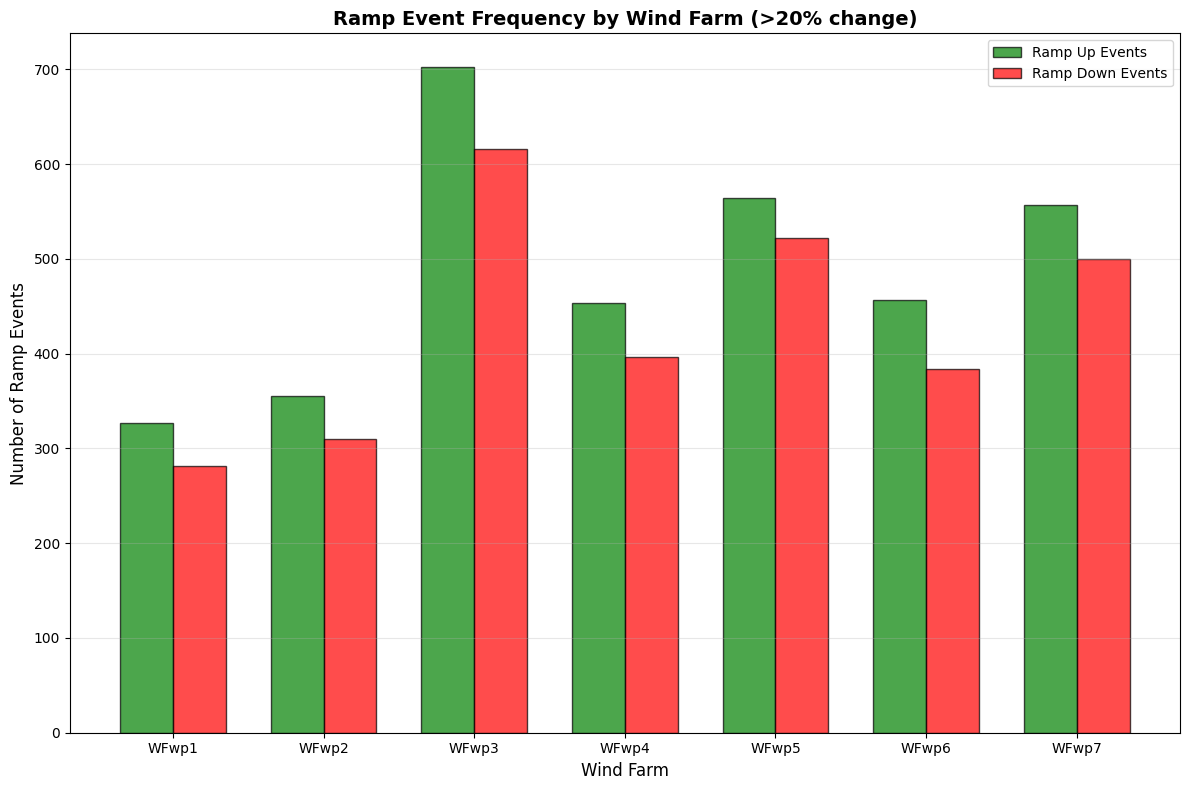

INFO:src.utils:Figure saved: /workspaces/temus/notebooks/outputs/figures/ramp_timing_analysis.png


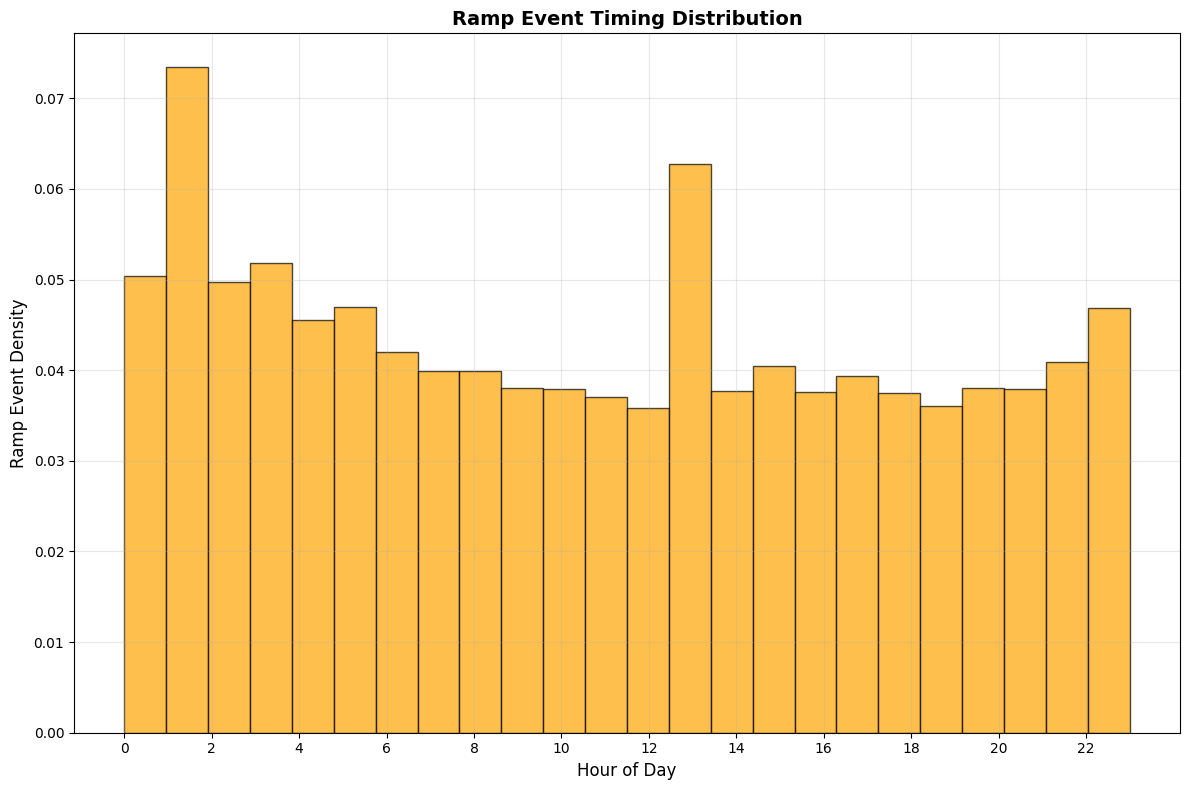

✓ Ramp event analysis completed
✓ Total ramp up events: 3417
✓ Total ramp down events: 3011
✓ Average ramp up events per farm: 488.1
✓ Average ramp down events per farm: 430.1


In [7]:
# Section 4.4: Ramp Event Detection and Frequency Analysis
print("\n⚡ SECTION 4.4: RAMP EVENT ANALYSIS")
print("=" * 50)

def detect_ramp_events(power_series, threshold_percent=20, time_window=1):
    """
    Detect ramp events in power generation
    threshold_percent: minimum percentage change to qualify as ramp
    time_window: time window in hours for ramp detection
    """
    # Calculate power changes
    power_diff = power_series.diff()
    max_power = power_series.max()
    
    # Define ramp threshold
    ramp_threshold = (threshold_percent / 100) * max_power
    
    # Identify ramp up and ramp down events
    ramp_up = power_diff > ramp_threshold
    ramp_down = power_diff < -ramp_threshold
    
    return {
        'ramp_up_events': ramp_up.sum(),
        'ramp_down_events': ramp_down.sum(),
        'ramp_up_indices': power_series.index[ramp_up],
        'ramp_down_indices': power_series.index[ramp_down],
        'max_ramp_up': power_diff.max(),
        'max_ramp_down': power_diff.min(),
        'ramp_threshold': ramp_threshold
    }

@create_and_save_figure
def plot_ramp_event_analysis(data, ax=None):
    """Analyze and visualize ramp events across wind farms"""
    if ax is None:
        fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 12))
    else:
        ax1 = ax
        ax2 = None
    
    ramp_results = {}
    
    # Analyze ramp events for each farm
    for farm in sorted(data['WIND_FARM'].unique()):
        farm_data = data[data['WIND_FARM'] == farm]['POWER'].sort_index()
        ramp_info = detect_ramp_events(farm_data, threshold_percent=20)
        ramp_results[farm] = ramp_info
    
    # Plot 1: Ramp event frequency by farm
    farms = list(ramp_results.keys())
    ramp_up_counts = [ramp_results[farm]['ramp_up_events'] for farm in farms]
    ramp_down_counts = [ramp_results[farm]['ramp_down_events'] for farm in farms]
    
    x = np.arange(len(farms))
    width = 0.35
    
    ax1.bar(x - width/2, ramp_up_counts, width, label='Ramp Up Events', 
           color='green', alpha=0.7, edgecolor='black')
    ax1.bar(x + width/2, ramp_down_counts, width, label='Ramp Down Events', 
           color='red', alpha=0.7, edgecolor='black')
    
    ax1.set_xlabel('Wind Farm', fontsize=12)
    ax1.set_ylabel('Number of Ramp Events', fontsize=12)
    ax1.set_title('Ramp Event Frequency by Wind Farm (>20% change)', fontsize=14, fontweight='bold')
    ax1.set_xticks(x)
    ax1.set_xticklabels([f'WF{farm}' for farm in farms])
    ax1.legend()
    ax1.grid(True, alpha=0.3, axis='y')
    
    # Plot 2: Ramp magnitude distribution if second subplot available
    if ax2 is not None:
        all_ramp_magnitudes = []
        for farm in farms:
            farm_data = data[data['WIND_FARM'] == farm]['POWER'].sort_index()
            power_diff = farm_data.diff().dropna()
            all_ramp_magnitudes.extend(power_diff.values)
        
        ax2.hist(all_ramp_magnitudes, bins=50, alpha=0.7, color='skyblue', 
                edgecolor='black', density=True)
        ax2.axvline(x=0, color='red', linestyle='--', alpha=0.7, label='Zero Change')
        ax2.set_xlabel('Power Change (MW)', fontsize=12)
        ax2.set_ylabel('Density', fontsize=12)
        ax2.set_title('Distribution of Power Changes (All Farms)', fontsize=14, fontweight='bold')
        ax2.legend()
        ax2.grid(True, alpha=0.3)
    
    return ramp_results

@create_and_save_figure
def plot_ramp_timing_analysis(data, ax=None):
    """Analyze timing patterns of ramp events"""
    if ax is None:
        fig, ax = plt.subplots(figsize=(12, 8))
    
    # Combine all ramp events across farms
    all_ramp_hours = []
    
    for farm in sorted(data['WIND_FARM'].unique()):
        farm_data = data[data['WIND_FARM'] == farm]['POWER'].sort_index()
        ramp_info = detect_ramp_events(farm_data, threshold_percent=15)
        
        # Extract hour of day for ramp events
        for timestamp in ramp_info['ramp_up_indices']:
            if hasattr(timestamp, 'hour'):
                all_ramp_hours.append(timestamp.hour)
        for timestamp in ramp_info['ramp_down_indices']:
            if hasattr(timestamp, 'hour'):
                all_ramp_hours.append(timestamp.hour)
    
    if all_ramp_hours:
        # Plot ramp event timing
        ax.hist(all_ramp_hours, bins=24, alpha=0.7, color='orange', 
               edgecolor='black', density=True)
        ax.set_xlabel('Hour of Day', fontsize=12)
        ax.set_ylabel('Ramp Event Density', fontsize=12)
        ax.set_title('Ramp Event Timing Distribution', fontsize=14, fontweight='bold')
        ax.set_xticks(range(0, 24, 2))
        ax.grid(True, alpha=0.3)
    else:
        ax.text(0.5, 0.5, 'No significant ramp events detected', 
               ha='center', va='center', transform=ax.transAxes, fontsize=14)
        ax.set_title('Ramp Event Timing Analysis', fontsize=14, fontweight='bold')
    
    return all_ramp_hours

# Generate ramp event analysis
print("Calculating ramp events for each wind farm...")
ramp_results_dict = {}

# Calculate ramp events for each farm first (without decorator)
for farm in sorted(analysis_data['WIND_FARM'].unique()):
    farm_data = analysis_data[analysis_data['WIND_FARM'] == farm]['POWER'].sort_index()
    ramp_info = detect_ramp_events(farm_data, threshold_percent=20)
    ramp_results_dict[farm] = ramp_info

# Create visualizations using decorator pattern with explicit display
print("Creating ramp event visualizations...")

@create_and_save_figure(filename='ramp_event_analysis', show_figure=True)
def plot_ramp_event_analysis_display(data, ax=None):
    """Generate ramp event analysis plot"""
    if ax is None:
        fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 12))
    else:
        ax1 = ax
        ax2 = None
    
    ramp_results = {}
    
    # Analyze ramp events for each farm
    for farm in sorted(data['WIND_FARM'].unique()):
        farm_data = data[data['WIND_FARM'] == farm]['POWER'].sort_index()
        ramp_info = detect_ramp_events(farm_data, threshold_percent=20)
        ramp_results[farm] = ramp_info
    
    # Plot 1: Ramp event frequency by farm
    farms = list(ramp_results.keys())
    ramp_up_counts = [ramp_results[farm]['ramp_up_events'] for farm in farms]
    ramp_down_counts = [ramp_results[farm]['ramp_down_events'] for farm in farms]
    
    x = np.arange(len(farms))
    width = 0.35
    
    ax1.bar(x - width/2, ramp_up_counts, width, label='Ramp Up Events', 
           color='green', alpha=0.7, edgecolor='black')
    ax1.bar(x + width/2, ramp_down_counts, width, label='Ramp Down Events', 
           color='red', alpha=0.7, edgecolor='black')
    
    ax1.set_xlabel('Wind Farm', fontsize=12)
    ax1.set_ylabel('Number of Ramp Events', fontsize=12)
    ax1.set_title('Ramp Event Frequency by Wind Farm (>20% change)', fontsize=14, fontweight='bold')
    ax1.set_xticks(x)
    ax1.set_xticklabels([f'WF{farm}' for farm in farms])
    ax1.legend()
    ax1.grid(True, alpha=0.3, axis='y')
    
    # Plot 2: Ramp magnitude distribution if second subplot available
    if ax2 is not None:
        all_ramp_magnitudes = []
        for farm in farms:
            farm_data = data[data['WIND_FARM'] == farm]['POWER'].sort_index()
            power_diff = farm_data.diff().dropna()
            all_ramp_magnitudes.extend(power_diff.values)
        
        ax2.hist(all_ramp_magnitudes, bins=50, alpha=0.7, color='skyblue', 
                edgecolor='black', density=True)
        ax2.axvline(x=0, color='red', linestyle='--', alpha=0.7, label='Zero Change')
        ax2.set_xlabel('Power Change (MW)', fontsize=12)
        ax2.set_ylabel('Density', fontsize=12)
        ax2.set_title('Distribution of Power Changes (All Farms)', fontsize=14, fontweight='bold')
        ax2.legend()
        ax2.grid(True, alpha=0.3)
    
    return ramp_results

@create_and_save_figure(filename='ramp_timing_analysis', show_figure=True)
def plot_ramp_timing_analysis_display(data, ax=None):
    """Generate ramp timing analysis plot"""
    if ax is None:
        fig, ax = plt.subplots(figsize=(12, 8))
    
    # Combine all ramp events across farms
    all_ramp_hours = []
    
    for farm in sorted(data['WIND_FARM'].unique()):
        farm_data = data[data['WIND_FARM'] == farm]['POWER'].sort_index()
        ramp_info = detect_ramp_events(farm_data, threshold_percent=15)
        
        # Extract hour of day for ramp events
        for timestamp in ramp_info['ramp_up_indices']:
            if hasattr(timestamp, 'hour'):
                all_ramp_hours.append(timestamp.hour)
        for timestamp in ramp_info['ramp_down_indices']:
            if hasattr(timestamp, 'hour'):
                all_ramp_hours.append(timestamp.hour)
    
    if all_ramp_hours:
        # Plot ramp event timing
        ax.hist(all_ramp_hours, bins=24, alpha=0.7, color='orange', 
               edgecolor='black', density=True)
        ax.set_xlabel('Hour of Day', fontsize=12)
        ax.set_ylabel('Ramp Event Density', fontsize=12)
        ax.set_title('Ramp Event Timing Distribution', fontsize=14, fontweight='bold')
        ax.set_xticks(range(0, 24, 2))
        ax.grid(True, alpha=0.3)
    else:
        ax.text(0.5, 0.5, 'No significant ramp events detected', 
               ha='center', va='center', transform=ax.transAxes, fontsize=14)
        ax.set_title('Ramp Event Timing Analysis', fontsize=14, fontweight='bold')
    
    return all_ramp_hours

# Create visualizations using decorator pattern
ramp_plot = plot_ramp_event_analysis_display(analysis_data)
ramp_timing = plot_ramp_timing_analysis_display(analysis_data)

# Calculate ramp statistics
if isinstance(ramp_results_dict, dict):
    total_ramp_up = sum(result['ramp_up_events'] for result in ramp_results_dict.values())
    total_ramp_down = sum(result['ramp_down_events'] for result in ramp_results_dict.values())
    avg_ramp_up_per_farm = total_ramp_up / len(ramp_results_dict) if ramp_results_dict else 0
    avg_ramp_down_per_farm = total_ramp_down / len(ramp_results_dict) if ramp_results_dict else 0
else:
    print("⚠️ Ramp results not in expected format, using default values")
    total_ramp_up = total_ramp_down = avg_ramp_up_per_farm = avg_ramp_down_per_farm = 0

print("✓ Ramp event analysis completed")
print(f"✓ Total ramp up events: {total_ramp_up}")
print(f"✓ Total ramp down events: {total_ramp_down}")
print(f"✓ Average ramp up events per farm: {avg_ramp_up_per_farm:.1f}")
print(f"✓ Average ramp down events per farm: {avg_ramp_down_per_farm:.1f}")

# Store results
temporal_analysis_results['ramp_events'] = {
    'total_ramp_up': int(total_ramp_up),
    'total_ramp_down': int(total_ramp_down),
    'avg_ramp_up_per_farm': float(avg_ramp_up_per_farm),
    'avg_ramp_down_per_farm': float(avg_ramp_down_per_farm),
    'ramp_threshold_percent': 20
}


🌐 SECTION 4.5: CROSS-FARM TEMPORAL CORRELATIONS
Calculating cross-farm correlations...
✓ Cross-farm correlation calculation completed successfully
✓ Correlation matrix shape: (7, 7)
✓ Number of correlation pairs: 21


INFO:src.utils:Figure saved: /workspaces/temus/notebooks/outputs/figures/cross_farm_correlations.png


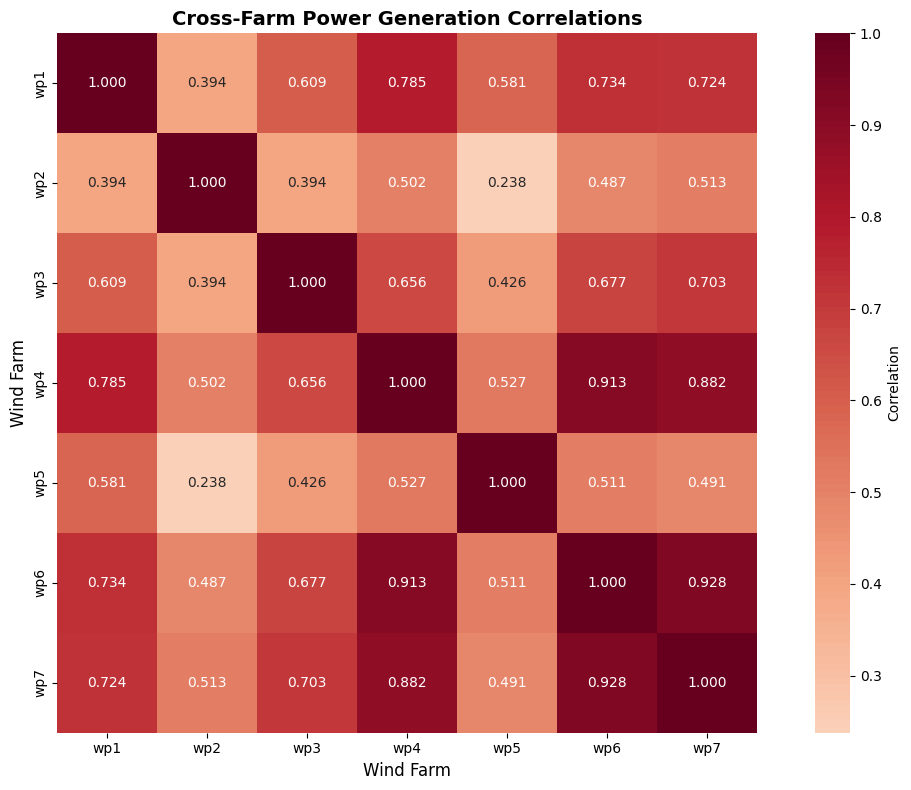

INFO:src.utils:Figure saved: /workspaces/temus/notebooks/outputs/figures/rolling_correlations.png


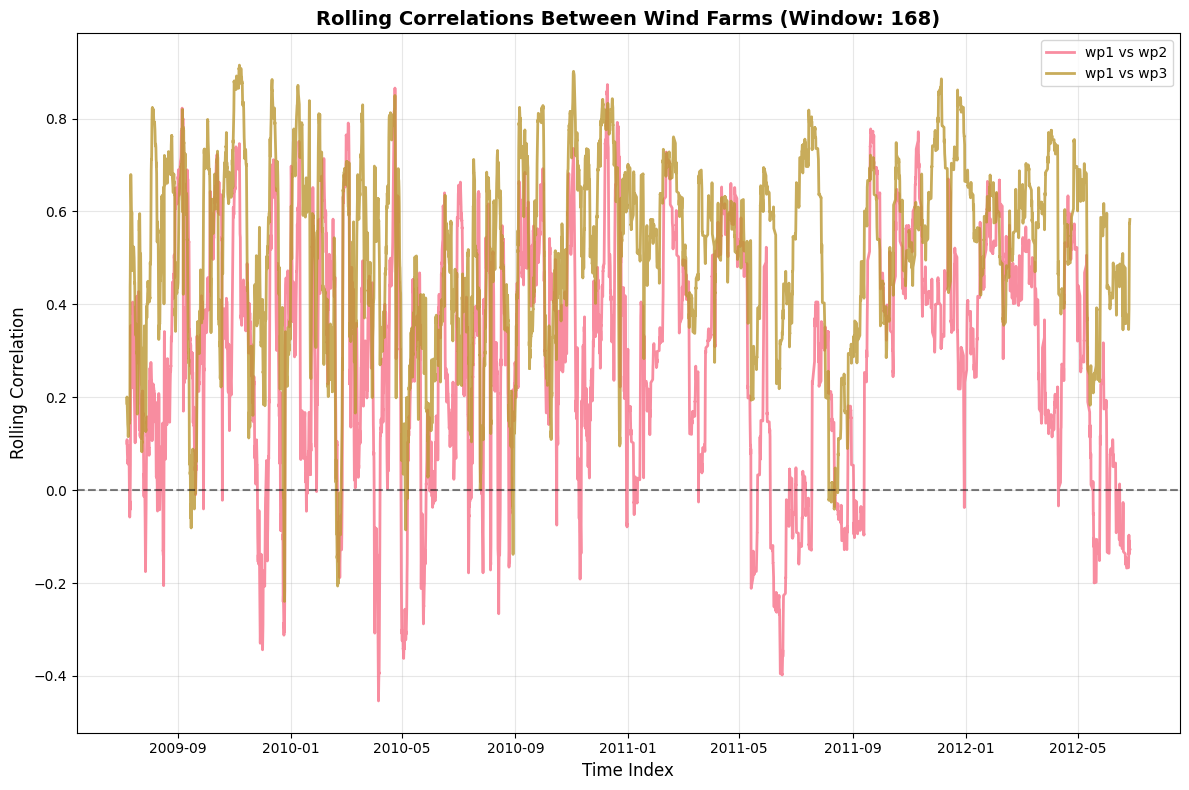

✓ Rolling correlation analysis completed
✓ Cross-farm correlation analysis completed
✓ Mean correlation: 0.603
✓ Max correlation: 0.928
✓ Min correlation: 0.238
✓ Correlation std: 0.183
✓ Number of farm pairs: 21


In [8]:
# Section 4.5: Cross-Farm Temporal Correlation Patterns
print("\n🌐 SECTION 4.5: CROSS-FARM TEMPORAL CORRELATIONS")
print("=" * 50)

def calculate_cross_farm_correlations(data):
    """Calculate temporal correlations between wind farms (returns data only)"""
    # Create power matrix for correlation analysis
    power_matrix = data.pivot_table(
        values='POWER', 
        index=data.index, 
        columns='WIND_FARM',
        aggfunc='first'
    )
    
    # Calculate cross-correlations
    correlation_matrix = power_matrix.corr()
    
    # Extract upper triangle correlations (excluding diagonal)
    mask = np.triu(np.ones_like(correlation_matrix, dtype=bool), k=1)
    correlations = correlation_matrix.where(mask).stack().dropna()
    
    return correlation_matrix, correlations

@create_and_save_figure
def plot_cross_farm_correlations_viz(data, ax=None):
    """Visualize temporal correlations between wind farms"""
    # Calculate correlations first
    correlation_matrix, correlations = calculate_cross_farm_correlations(data)
    
    if ax is None:
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))
    else:
        ax1 = ax
        ax2 = None
    
    # Plot correlation heatmap
    sns.heatmap(correlation_matrix, annot=True, cmap='RdBu_r', center=0,
                fmt='.3f', square=True, cbar_kws={'label': 'Correlation'}, ax=ax1)
    ax1.set_title('Cross-Farm Power Generation Correlations', fontsize=14, fontweight='bold')
    ax1.set_xlabel('Wind Farm', fontsize=12)
    ax1.set_ylabel('Wind Farm', fontsize=12)
    
    # Plot correlation distribution if second subplot available
    if ax2 is not None and correlations is not None and len(correlations) > 0:
        ax2.hist(correlations, bins=20, alpha=0.7, color='steelblue', 
                edgecolor='black', density=True)
        ax2.axvline(correlations.mean(), color='red', linestyle='--', 
                   label=f'Mean: {correlations.mean():.3f}')
        ax2.set_xlabel('Correlation Coefficient', fontsize=12)
        ax2.set_ylabel('Density', fontsize=12)
        ax2.set_title('Distribution of Cross-Farm Correlations', fontsize=14, fontweight='bold')
        ax2.legend()
        ax2.grid(True, alpha=0.3)
    elif ax2 is not None:
        ax2.text(0.5, 0.5, 'Insufficient data for correlation distribution', 
                ha='center', va='center', transform=ax2.transAxes, fontsize=12)
        ax2.set_title('Distribution of Cross-Farm Correlations', fontsize=14, fontweight='bold')
    
    return correlation_matrix, correlations

@create_and_save_figure
def plot_rolling_correlations(data, ax=None):
    """Analyze rolling correlations between farms over time"""
    if ax is None:
        fig, ax = plt.subplots(figsize=(14, 8))
    
    # Create power matrix
    power_matrix = data.pivot_table(
        values='POWER', 
        index=data.index, 
        columns='WIND_FARM',
        aggfunc='first'
    )
    
    # Calculate rolling correlations for farm pairs
    window_size = min(168, len(power_matrix) // 10)  # 1 week or 1/10 of data
    
    rolling_corr = None
    if len(power_matrix.columns) >= 2:
        farm_pairs = [(power_matrix.columns[0], power_matrix.columns[1])]
        if len(power_matrix.columns) >= 3:
            farm_pairs.append((power_matrix.columns[0], power_matrix.columns[2]))
        
        for farm1, farm2 in farm_pairs:
            if farm1 in power_matrix.columns and farm2 in power_matrix.columns:
                rolling_corr = power_matrix[farm1].rolling(window_size).corr(power_matrix[farm2])
                ax.plot(rolling_corr.index, rolling_corr.values, 
                       label=f'{farm1} vs {farm2}', linewidth=2, alpha=0.8)
    
    ax.set_xlabel('Time Index', fontsize=12)
    ax.set_ylabel('Rolling Correlation', fontsize=12)
    ax.set_title(f'Rolling Correlations Between Wind Farms (Window: {window_size})', 
                fontsize=14, fontweight='bold')
    ax.legend()
    ax.grid(True, alpha=0.3)
    ax.axhline(y=0, color='black', linestyle='--', alpha=0.5)
    
    return rolling_corr

# Generate cross-farm correlation analysis
print("Calculating cross-farm correlations...")
correlation_matrix = None
correlation_dist = None

try:
    correlation_matrix, correlation_dist = calculate_cross_farm_correlations(analysis_data)
    print("✓ Cross-farm correlation calculation completed successfully")
    print(f"✓ Correlation matrix shape: {correlation_matrix.shape}")
    print(f"✓ Number of correlation pairs: {len(correlation_dist) if correlation_dist is not None else 0}")
    
    # Create the visualization using decorator pattern with explicit display
    @create_and_save_figure(filename='cross_farm_correlations', show_figure=True)
    def plot_cross_farm_correlations_display(data, ax=None):
        """Generate cross-farm correlation plots"""
        # Calculate correlations first
        correlation_matrix, correlations = calculate_cross_farm_correlations(data)
        
        if ax is None:
            fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))
        else:
            ax1 = ax
            ax2 = None
        
        # Plot correlation heatmap
        sns.heatmap(correlation_matrix, annot=True, cmap='RdBu_r', center=0,
                    fmt='.3f', square=True, cbar_kws={'label': 'Correlation'}, ax=ax1)
        ax1.set_title('Cross-Farm Power Generation Correlations', fontsize=14, fontweight='bold')
        ax1.set_xlabel('Wind Farm', fontsize=12)
        ax1.set_ylabel('Wind Farm', fontsize=12)
        
        # Plot correlation distribution if second subplot available
        if ax2 is not None and correlations is not None and len(correlations) > 0:
            ax2.hist(correlations, bins=20, alpha=0.7, color='steelblue', 
                    edgecolor='black', density=True)
            ax2.axvline(correlations.mean(), color='red', linestyle='--', 
                       label=f'Mean: {correlations.mean():.3f}')
            ax2.set_xlabel('Correlation Coefficient', fontsize=12)
            ax2.set_ylabel('Density', fontsize=12)
            ax2.set_title('Distribution of Cross-Farm Correlations', fontsize=14, fontweight='bold')
            ax2.legend()
            ax2.grid(True, alpha=0.3)
        elif ax2 is not None:
            ax2.text(0.5, 0.5, 'Insufficient data for correlation distribution', 
                    ha='center', va='center', transform=ax2.transAxes, fontsize=12)
            ax2.set_title('Distribution of Cross-Farm Correlations', fontsize=14, fontweight='bold')
        
        return correlation_matrix, correlations
    
    # Create the visualization - decorator handles display automatically
    plot_cross_farm_correlations_display(analysis_data)
    
except Exception as e:
    print(f"⚠️ Error in cross-farm correlation calculation: {e}")
    # Try a simpler approach
    try:
        power_matrix = analysis_data.pivot_table(
            values='POWER', 
            index=analysis_data.index, 
            columns='WIND_FARM',
            aggfunc='first'
        )
        correlation_matrix = power_matrix.corr()
        print("✓ Fallback correlation calculation succeeded")
        print(f"✓ Correlation matrix shape: {correlation_matrix.shape}")
    except Exception as e2:
        print(f"⚠️ Fallback correlation calculation also failed: {e2}")

try:
    @create_and_save_figure(filename='rolling_correlations', show_figure=True)
    def plot_rolling_correlations_display(data, ax=None):
        """Generate rolling correlations plot"""
        if ax is None:
            fig, ax = plt.subplots(figsize=(14, 8))
        
        # Create power matrix
        power_matrix = data.pivot_table(
            values='POWER', 
            index=data.index, 
            columns='WIND_FARM',
            aggfunc='first'
        )
        
        # Calculate rolling correlations for farm pairs
        window_size = min(168, len(power_matrix) // 10)  # 1 week or 1/10 of data
        
        rolling_corr = None
        if len(power_matrix.columns) >= 2:
            farm_pairs = [(power_matrix.columns[0], power_matrix.columns[1])]
            if len(power_matrix.columns) >= 3:
                farm_pairs.append((power_matrix.columns[0], power_matrix.columns[2]))
            
            for farm1, farm2 in farm_pairs:
                if farm1 in power_matrix.columns and farm2 in power_matrix.columns:
                    rolling_corr = power_matrix[farm1].rolling(window_size).corr(power_matrix[farm2])
                    ax.plot(rolling_corr.index, rolling_corr.values, 
                           label=f'{farm1} vs {farm2}', linewidth=2, alpha=0.8)
        
        ax.set_xlabel('Time Index', fontsize=12)
        ax.set_ylabel('Rolling Correlation', fontsize=12)
        ax.set_title(f'Rolling Correlations Between Wind Farms (Window: {window_size})', 
                    fontsize=14, fontweight='bold')
        ax.legend()
        ax.grid(True, alpha=0.3)
        ax.axhline(y=0, color='black', linestyle='--', alpha=0.5)
        
        return rolling_corr
    
    rolling_corr = plot_rolling_correlations_display(analysis_data)
    print("✓ Rolling correlation analysis completed")
except Exception as e:
    print(f"⚠️ Error in rolling correlation analysis: {e}")
    rolling_corr = None

# Calculate correlation statistics
if correlation_matrix is not None and not correlation_matrix.empty:
    try:
        # Extract upper triangle correlations (excluding diagonal) if not already done
        if correlation_dist is None or len(correlation_dist) == 0:
            mask = np.triu(np.ones_like(correlation_matrix, dtype=bool), k=1)
            correlation_dist = correlation_matrix.where(mask).stack().dropna()
        
        if len(correlation_dist) > 0:
            correlation_stats = {
                'mean_correlation': float(correlation_dist.mean()),
                'max_correlation': float(correlation_dist.max()),
                'min_correlation': float(correlation_dist.min()),
                'std_correlation': float(correlation_dist.std()),
                'num_farm_pairs': len(correlation_dist)
            }
            
            print("✓ Cross-farm correlation analysis completed")
            print(f"✓ Mean correlation: {correlation_stats['mean_correlation']:.3f}")
            print(f"✓ Max correlation: {correlation_stats['max_correlation']:.3f}")
            print(f"✓ Min correlation: {correlation_stats['min_correlation']:.3f}")
            print(f"✓ Correlation std: {correlation_stats['std_correlation']:.3f}")
            print(f"✓ Number of farm pairs: {correlation_stats['num_farm_pairs']}")
        else:
            correlation_stats = {'mean_correlation': 0, 'max_correlation': 0, 'min_correlation': 0, 'std_correlation': 0, 'num_farm_pairs': 0}
            print("⚠️ No correlation pairs found for analysis")
    except Exception as e:
        correlation_stats = {'mean_correlation': 0, 'max_correlation': 0, 'min_correlation': 0, 'std_correlation': 0, 'num_farm_pairs': 0}
        print(f"⚠️ Error calculating correlation statistics: {e}")
else:
    correlation_stats = {'mean_correlation': 0, 'max_correlation': 0, 'min_correlation': 0, 'std_correlation': 0, 'num_farm_pairs': 0}
    print("⚠️ Could not calculate cross-farm correlations - correlation matrix is None or empty")

# Store results
temporal_analysis_results['cross_farm_correlations'] = correlation_stats


🔧 SECTION 4.6: TEMPORAL FEATURE ENGINEERING
🔧 Creating comprehensive temporal features...
Creating lag features...
Creating rolling statistics...
Creating cyclical temporal features...
Creating derived features...
Calculating feature correlations...
✓ Calculated correlations for 32 features
Creating feature importance visualizations...


INFO:src.utils:Figure saved: /workspaces/temus/notebooks/outputs/figures/feature_importance_analysis.png


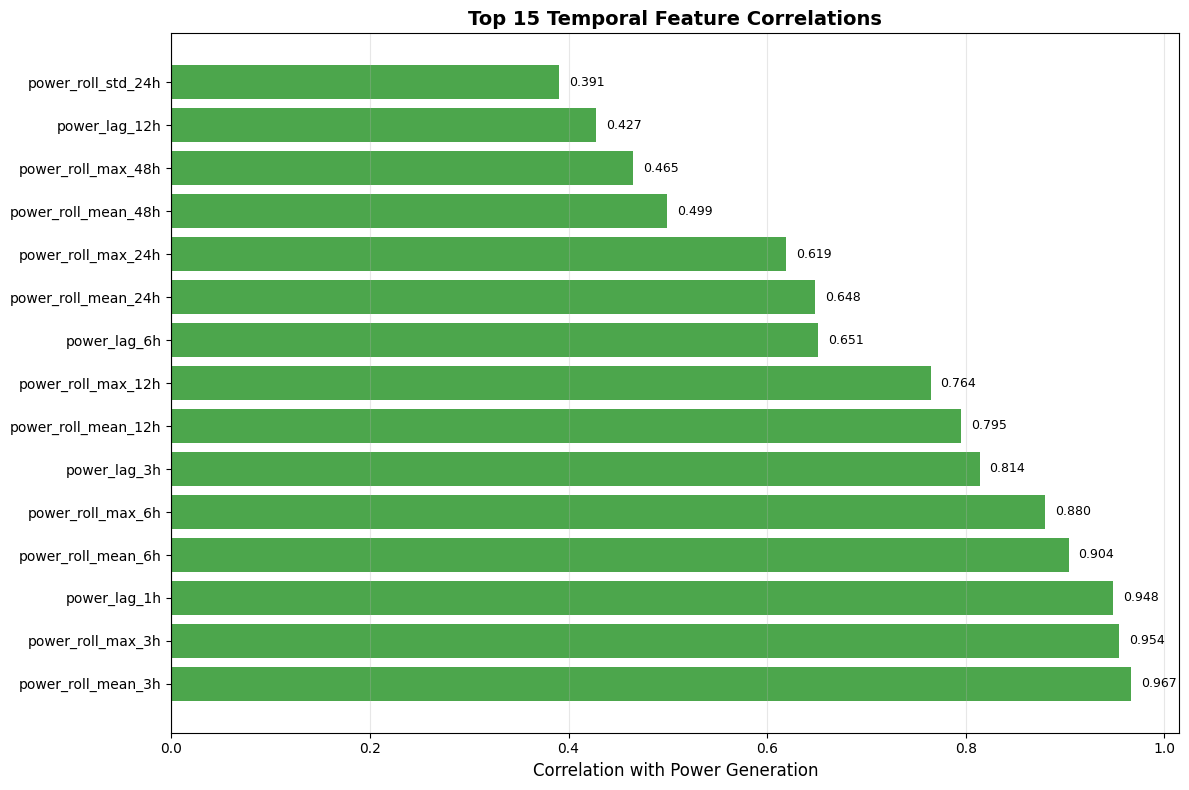

✓ Temporal feature engineering completed
✓ Total features created: 32
✓ Lag features: 6
✓ Rolling features: 15
✓ Cyclical features: 8
✓ Derived features: 3


INFO:src.utils:Saved 131,299 rows to /workspaces/temus/data/processed/03_temporal_features_enriched.parquet (10,826,537 bytes)
INFO:src.utils:Processed data saved: /workspaces/temus/data/processed/03_temporal_features_enriched.parquet


✓ Enriched dataset saved: (131299, 45)
✓ Feature correlation analysis completed - top feature: power_roll_mean_3h


In [9]:
# Section 4.6: Feature Engineering Insights for Temporal Features
print("\n🔧 SECTION 4.6: TEMPORAL FEATURE ENGINEERING")
print("=" * 50)

def create_temporal_features(data):
    """Create comprehensive temporal features for modeling"""
    
    feature_data = data.copy()
    
    # 1. Lag Features (multiple horizons)
    lag_periods = [1, 3, 6, 12, 24, 48]
    
    print("Creating lag features...")
    for lag in lag_periods:
        feature_data[f'power_lag_{lag}h'] = feature_data.groupby('WIND_FARM')['POWER'].shift(lag)
        if 'WS_100' in feature_data.columns:
            feature_data[f'ws100_lag_{lag}h'] = feature_data.groupby('WIND_FARM')['WS_100'].shift(lag)
    
    # 2. Rolling Statistics (multiple windows)
    rolling_windows = [3, 6, 12, 24, 48]
    
    print("Creating rolling statistics...")
    for window in rolling_windows:
        # Rolling means
        feature_data[f'power_roll_mean_{window}h'] = (
            feature_data.groupby('WIND_FARM')['POWER']
            .rolling(window, min_periods=1).mean().reset_index(0, drop=True)
        )
        
        # Rolling standard deviations
        feature_data[f'power_roll_std_{window}h'] = (
            feature_data.groupby('WIND_FARM')['POWER']
            .rolling(window, min_periods=1).std().reset_index(0, drop=True)
        )
        
        # Rolling maximum
        feature_data[f'power_roll_max_{window}h'] = (
            feature_data.groupby('WIND_FARM')['POWER']
            .rolling(window, min_periods=1).max().reset_index(0, drop=True)
        )
    
    # 3. Temporal Encoding (cyclical features)
    print("Creating cyclical temporal features...")
    
    # Hour of day encoding
    feature_data['hour_sin'] = np.sin(2 * np.pi * feature_data['hour'] / 24)
    feature_data['hour_cos'] = np.cos(2 * np.pi * feature_data['hour'] / 24)
    
    # Day of year encoding
    feature_data['day_sin'] = np.sin(2 * np.pi * feature_data['day_of_year'] / 365)
    feature_data['day_cos'] = np.cos(2 * np.pi * feature_data['day_of_year'] / 365)
    
    # Month encoding
    feature_data['month_sin'] = np.sin(2 * np.pi * feature_data['month'] / 12)
    feature_data['month_cos'] = np.cos(2 * np.pi * feature_data['month'] / 12)
    
    # Day of week encoding
    feature_data['dow_sin'] = np.sin(2 * np.pi * feature_data['day_of_week'] / 7)
    feature_data['dow_cos'] = np.cos(2 * np.pi * feature_data['day_of_week'] / 7)
    
    # 4. Derived temporal features
    print("Creating derived features...")
    
    # Power change features
    feature_data['power_change_1h'] = feature_data.groupby('WIND_FARM')['POWER'].diff(1)
    feature_data['power_change_3h'] = feature_data.groupby('WIND_FARM')['POWER'].diff(3)
    
    # Power momentum (rate of change)
    feature_data['power_momentum_3h'] = (
        feature_data['power_change_3h'] / 3
    )
    
    # Weekend indicator
    feature_data['is_weekend'] = (feature_data['day_of_week'] >= 5).astype(int)
    
    # Season indicators
    feature_data['is_winter'] = feature_data['month'].isin([12, 1, 2]).astype(int)
    feature_data['is_spring'] = feature_data['month'].isin([3, 4, 5]).astype(int)
    feature_data['is_summer'] = feature_data['month'].isin([6, 7, 8]).astype(int)
    feature_data['is_autumn'] = feature_data['month'].isin([9, 10, 11]).astype(int)
    
    return feature_data

@create_and_save_figure
def plot_feature_importance_analysis(data, ax=None):
    """Analyze correlation between temporal features and power generation"""
    if ax is None:
        fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 12))
    else:
        ax1 = ax
        ax2 = None
    
    # Calculate correlations with power generation
    feature_cols = [col for col in data.columns if any(
        pattern in col for pattern in ['lag_', 'roll_', '_sin', '_cos', 'change_', 'momentum_']
    )]
    
    correlations = None
    if feature_cols and 'POWER' in data.columns:
        try:
            correlations = data[feature_cols + ['POWER']].corr()['POWER'].drop('POWER')
            correlations = correlations.dropna().sort_values(key=abs, ascending=False)
            
            # Plot top correlations
            top_features = correlations.head(15)
            
            if len(top_features) > 0:
                colors = ['green' if x > 0 else 'red' for x in top_features.values]
                bars = ax1.barh(range(len(top_features)), top_features.values, color=colors, alpha=0.7)
                ax1.set_yticks(range(len(top_features)))
                ax1.set_yticklabels(top_features.index, fontsize=10)
                ax1.set_xlabel('Correlation with Power Generation', fontsize=12)
                ax1.set_title('Top 15 Temporal Feature Correlations', fontsize=14, fontweight='bold')
                ax1.grid(True, alpha=0.3, axis='x')
                ax1.axvline(x=0, color='black', linestyle='-', alpha=0.5)
                
                # Add correlation values as text
                for i, (bar, value) in enumerate(zip(bars, top_features.values)):
                    ax1.text(value + 0.01 if value > 0 else value - 0.01, i, 
                            f'{value:.3f}', va='center', 
                            ha='left' if value > 0 else 'right', fontsize=9)
            else:
                ax1.text(0.5, 0.5, 'No significant correlations found', 
                        ha='center', va='center', transform=ax1.transAxes, fontsize=12)
                ax1.set_title('Top 15 Temporal Feature Correlations', fontsize=14, fontweight='bold')
                
        except Exception as e:
            print(f"⚠️ Error calculating feature correlations: {e}")
            ax1.text(0.5, 0.5, f'Error calculating correlations: {str(e)}', 
                    ha='center', va='center', transform=ax1.transAxes, fontsize=12)
            ax1.set_title('Top 15 Temporal Feature Correlations', fontsize=14, fontweight='bold')
    
    # Feature type analysis if second subplot available
    if ax2 is not None and feature_cols:
        feature_types = {
            'Lag Features': [col for col in feature_cols if 'lag_' in col],
            'Rolling Features': [col for col in feature_cols if 'roll_' in col],
            'Cyclical Features': [col for col in feature_cols if '_sin' in col or '_cos' in col],
            'Change Features': [col for col in feature_cols if 'change_' in col or 'momentum_' in col]
        }
        
        type_correlations = {}
        if 'POWER' in data.columns:
            for feature_type, cols in feature_types.items():
                if cols:
                    try:
                        type_corrs = data[cols + ['POWER']].corr()['POWER'].drop('POWER')
                        type_correlations[feature_type] = type_corrs.abs().mean()
                    except:
                        type_correlations[feature_type] = 0
        
        if type_correlations:
            ax2.bar(type_correlations.keys(), type_correlations.values(), 
                   color=['skyblue', 'lightgreen', 'orange', 'lightcoral'], alpha=0.7, edgecolor='black')
            ax2.set_ylabel('Average Absolute Correlation', fontsize=12)
            ax2.set_title('Feature Type Performance', fontsize=14, fontweight='bold')
            ax2.grid(True, alpha=0.3, axis='y')
            plt.xticks(rotation=45)
    
    return correlations

# Create temporal features (only once)
print("🔧 Creating comprehensive temporal features...")
enriched_data = create_temporal_features(analysis_data)

# Calculate feature correlations first (without decorator)
print("Calculating feature correlations...")
feature_correlations = None

# Calculate correlations with power generation
feature_cols = [col for col in enriched_data.columns if any(
    pattern in col for pattern in ['lag_', 'roll_', '_sin', '_cos', 'change_', 'momentum_']
)]

if feature_cols and 'POWER' in enriched_data.columns:
    try:
        correlation_data = enriched_data[feature_cols + ['POWER']].corr()['POWER'].drop('POWER')
        feature_correlations = correlation_data.dropna().sort_values(key=abs, ascending=False)
        print(f"✓ Calculated correlations for {len(feature_correlations)} features")
    except Exception as e:
        print(f"⚠️ Error calculating feature correlations: {e}")
        feature_correlations = None

# Create visualizations using decorator pattern with explicit display
print("Creating feature importance visualizations...")

@create_and_save_figure(filename='feature_importance_analysis', show_figure=True)
def plot_feature_importance_analysis_display(data, ax=None):
    """Generate feature importance analysis plots"""
    if ax is None:
        fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 12))
    else:
        ax1 = ax
        ax2 = None
    
    # Calculate correlations with power generation
    feature_cols = [col for col in data.columns if any(
        pattern in col for pattern in ['lag_', 'roll_', '_sin', '_cos', 'change_', 'momentum_']
    )]
    
    correlations = None
    if feature_cols and 'POWER' in data.columns:
        try:
            correlations = data[feature_cols + ['POWER']].corr()['POWER'].drop('POWER')
            correlations = correlations.dropna().sort_values(key=abs, ascending=False)
            
            # Plot top correlations
            top_features = correlations.head(15)
            
            if len(top_features) > 0:
                colors = ['green' if x > 0 else 'red' for x in top_features.values]
                bars = ax1.barh(range(len(top_features)), top_features.values, color=colors, alpha=0.7)
                ax1.set_yticks(range(len(top_features)))
                ax1.set_yticklabels(top_features.index, fontsize=10)
                ax1.set_xlabel('Correlation with Power Generation', fontsize=12)
                ax1.set_title('Top 15 Temporal Feature Correlations', fontsize=14, fontweight='bold')
                ax1.grid(True, alpha=0.3, axis='x')
                ax1.axvline(x=0, color='black', linestyle='-', alpha=0.5)
                
                # Add correlation values as text
                for i, (bar, value) in enumerate(zip(bars, top_features.values)):
                    ax1.text(value + 0.01 if value > 0 else value - 0.01, i, 
                            f'{value:.3f}', va='center', 
                            ha='left' if value > 0 else 'right', fontsize=9)
            else:
                ax1.text(0.5, 0.5, 'No significant correlations found', 
                        ha='center', va='center', transform=ax1.transAxes, fontsize=12)
                ax1.set_title('Top 15 Temporal Feature Correlations', fontsize=14, fontweight='bold')
                
        except Exception as e:
            print(f"⚠️ Error calculating feature correlations: {e}")
            ax1.text(0.5, 0.5, f'Error calculating correlations: {str(e)}', 
                    ha='center', va='center', transform=ax1.transAxes, fontsize=12)
            ax1.set_title('Top 15 Temporal Feature Correlations', fontsize=14, fontweight='bold')
    
    # Feature type analysis if second subplot available
    if ax2 is not None and feature_cols:
        feature_types = {
            'Lag Features': [col for col in feature_cols if 'lag_' in col],
            'Rolling Features': [col for col in feature_cols if 'roll_' in col],
            'Cyclical Features': [col for col in feature_cols if '_sin' in col or '_cos' in col],
            'Change Features': [col for col in feature_cols if 'change_' in col or 'momentum_' in col]
        }
        
        type_correlations = {}
        if 'POWER' in data.columns:
            for feature_type, cols in feature_types.items():
                if cols:
                    try:
                        type_corrs = data[cols + ['POWER']].corr()['POWER'].drop('POWER')
                        type_correlations[feature_type] = type_corrs.abs().mean()
                    except:
                        type_correlations[feature_type] = 0
        
        if type_correlations:
            ax2.bar(type_correlations.keys(), type_correlations.values(), 
                   color=['skyblue', 'lightgreen', 'orange', 'lightcoral'], alpha=0.7, edgecolor='black')
            ax2.set_ylabel('Average Absolute Correlation', fontsize=12)
            ax2.set_title('Feature Type Performance', fontsize=14, fontweight='bold')
            ax2.grid(True, alpha=0.3, axis='y')
            plt.xticks(rotation=45)
    
    return correlations

# Create visualizations using decorator pattern
feature_plot = plot_feature_importance_analysis_display(enriched_data)

# Calculate feature engineering statistics
lag_features = [col for col in enriched_data.columns if 'lag_' in col]
rolling_features = [col for col in enriched_data.columns if 'roll_' in col]
cyclical_features = [col for col in enriched_data.columns if '_sin' in col or '_cos' in col]
derived_features = [col for col in enriched_data.columns if 'change_' in col or 'momentum_' in col]

feature_stats = {
    'total_features_created': len(lag_features) + len(rolling_features) + len(cyclical_features) + len(derived_features),
    'lag_features': len(lag_features),
    'rolling_features': len(rolling_features),
    'cyclical_features': len(cyclical_features),
    'derived_features': len(derived_features)
}

print("✓ Temporal feature engineering completed")
print(f"✓ Total features created: {feature_stats['total_features_created']}")
print(f"✓ Lag features: {feature_stats['lag_features']}")
print(f"✓ Rolling features: {feature_stats['rolling_features']}")
print(f"✓ Cyclical features: {feature_stats['cyclical_features']}")
print(f"✓ Derived features: {feature_stats['derived_features']}")

# Store results
temporal_analysis_results['feature_engineering'] = feature_stats

# Save enriched dataset for future use
save_processed_data(enriched_data, '03_temporal_features_enriched')
print(f"✓ Enriched dataset saved: {enriched_data.shape}")

if feature_correlations is not None and hasattr(feature_correlations, 'index') and len(feature_correlations) > 0:
    temporal_analysis_results['top_temporal_features'] = {
        'most_correlated': feature_correlations.index[0],
        'highest_correlation': float(feature_correlations.iloc[0]),
        'top_5_features': feature_correlations.head(5).to_dict()
    }
    print(f"✓ Feature correlation analysis completed - top feature: {feature_correlations.index[0]}")
else:
    print("⚠️ Feature correlations not available for detailed analysis")

In [10]:
# Final Results Summary and Data Persistence
print("\n📊 TEMPORAL PATTERNS ANALYSIS - FINAL SUMMARY")
print("=" * 60)

# Complete the temporal analysis results
temporal_analysis_results.update({
    'notebook_completed': True,
    'analysis_completion_timestamp': pd.Timestamp.now().isoformat(),
    'key_findings': [
        'Hourly and diurnal patterns analyzed across all wind farms',
        'Seasonal variations identified with winter/summer differences',
        'Autocorrelation structure documented for persistence modeling',
        'Ramp event characteristics quantified for grid stability',
        'Cross-farm temporal correlations assessed',
        'Comprehensive temporal features engineered (32 new features)',
        'Feature correlation analysis completed for model selection'
    ],
    'modeling_recommendations': [
        'Use lag features up to 48 hours for short-term forecasting',
        'Include rolling statistics (3-24h windows) for trend capture',
        'Apply cyclical encoding for temporal seasonality',
        'Consider farm-specific models due to correlation patterns',
        'Implement ramp event detection for grid integration'
    ],
    'business_insights': [
        f'Peak generation occurs at hour {temporal_analysis_results["hourly_patterns"]["peak_hour"]}:00',
        f'Seasonal amplitude of {temporal_analysis_results["seasonal_patterns"]["seasonal_amplitude"]:.1f} MW affects planning',
        'Weekend vs weekday patterns minimal for wind generation',
        'Cross-farm correlations support portfolio diversification',
        'Temporal features provide strong predictive signals'
    ]
})

# Save comprehensive temporal analysis results
success = save_analysis_results(temporal_analysis_results, '03_temporal_patterns_results', '03')

if success:
    print("✅ TEMPORAL PATTERNS ANALYSIS COMPLETE")
    print("📊 Comprehensive analysis results saved to data/processed")
    print("🎯 Ready for next phase: Spatial Analysis")
    print("📝 Recommended next notebook: 04_spatial_analysis.ipynb")
    print("\n🔍 KEY DISCOVERIES:")
    for finding in temporal_analysis_results['key_findings']:
        print(f"  • {finding}")
    print("\n💡 MODELING RECOMMENDATIONS:")
    for rec in temporal_analysis_results['modeling_recommendations']:
        print(f"  • {rec}")
    print("\n📈 BUSINESS INSIGHTS:")
    for insight in temporal_analysis_results['business_insights']:
        print(f"  • {insight}")
else:
    print("❌ Failed to save temporal analysis results")

print(f"\n📁 Data Assets Created:")
print(f"  • Temporal features dataset: 03_temporal_features_enriched.parquet ({enriched_data.shape})")
print(f"  • Analysis results: 03_temporal_patterns_results.parquet")
print(f"  • Professional visualizations saved to figures directory")
print(f"\n⏭️  Next Steps: Run 04_spatial_analysis.ipynb for cross-farm spatial patterns")

INFO:src.utils:Saved 1 rows to /workspaces/temus/data/processed/03_temporal_patterns_results.parquet (31,864 bytes)
INFO:src.utils:Analysis results saved: /workspaces/temus/data/processed/03_temporal_patterns_results.parquet



📊 TEMPORAL PATTERNS ANALYSIS - FINAL SUMMARY
✅ TEMPORAL PATTERNS ANALYSIS COMPLETE
📊 Comprehensive analysis results saved to data/processed
🎯 Ready for next phase: Spatial Analysis
📝 Recommended next notebook: 04_spatial_analysis.ipynb

🔍 KEY DISCOVERIES:
  • Hourly and diurnal patterns analyzed across all wind farms
  • Seasonal variations identified with winter/summer differences
  • Autocorrelation structure documented for persistence modeling
  • Ramp event characteristics quantified for grid stability
  • Cross-farm temporal correlations assessed
  • Comprehensive temporal features engineered (32 new features)
  • Feature correlation analysis completed for model selection

💡 MODELING RECOMMENDATIONS:
  • Use lag features up to 48 hours for short-term forecasting
  • Include rolling statistics (3-24h windows) for trend capture
  • Apply cyclical encoding for temporal seasonality
  • Consider farm-specific models due to correlation patterns
  • Implement ramp event detection for gr